# Setup Paths

In [1]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/home/angel/WIP/Research/SymbolicDensityEstimation


# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from tqdm import tqdm
from config_management.data_config_muon_decay import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import gc
import dill
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.affinity import scale


# Data Exploration

In [3]:
file_path = './data/MuonDecay.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['m13^2', 'm23^2']
samples = df[columns].to_numpy()
# Extract m13^2 and m23^2 columns
x1 = df['m13^2'] 
x2 = df['m23^2']

     # px_e      py_e      pz_e        e_e  px_vebar  py_vebar  pz_vebar  \
0 -0.024405 -0.955112  4.681573  70.162882  2.386838 -0.435416 -4.472082   
1  0.736816  4.934791 -5.654470  70.405029 -0.934946 -4.184292  4.924989   
2  2.188230  1.389730  2.652483  70.098184 -3.878535 -1.019773 -4.033545   
3  2.715311 -6.962994  0.573012  70.400174 -2.755233  5.900690 -0.419577   
4  2.924203  3.120980 -2.147847  70.163414 -3.880531 -3.897870  0.165664   

    e_vebar     px_vm     py_vm     pz_vm      e_vm        m12^2      m13^2  \
0  5.087839 -2.362433  1.390527 -0.209490  2.749280  5655.112355  38.590468   
1  6.529773  0.198129 -0.750499  0.729481  1.065198  5917.829131   0.815496   
2  5.687922  1.690305 -0.369957  1.381062  2.213894  5738.632458  48.683332   
3  6.525757  0.039921  1.062304 -0.153434  1.074069  5916.445213   1.572809   
4  5.502668  0.956328  0.776890  1.982183  2.333917  5719.908892  38.507340   

         m23^2  
0  5290.297178  
1  5065.355374  
2  5196.684210  


## Scatter Plot

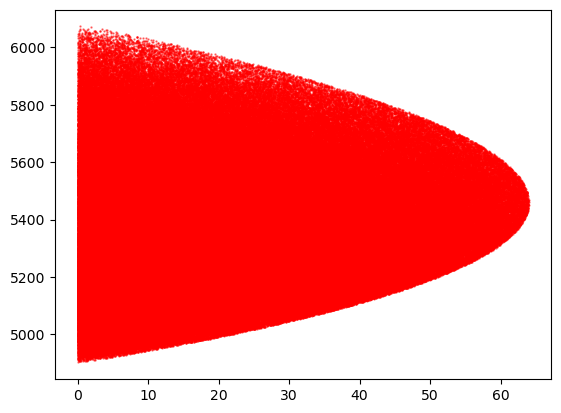

3174

In [4]:
plt.scatter(x1, x2, s=0.5, alpha=0.5, label='Data Points', color='red')
plt.show()
plt.close() 
gc.collect()

In [5]:
train_samples = np.loadtxt('data/processed_data/muon_decay_joint_data.csv', delimiter=',', skiprows=1)
test_samples = np.loadtxt('data/processed_data/muon_decay_test_samples.csv', delimiter=',', skiprows=1)
scaled_samples = np.concatenate([train_samples[:, 0:2], test_samples], axis=0)

hull = ConvexHull(scaled_samples)
hull_points = scaled_samples[hull.vertices]
polygon = Polygon(hull_points)
offset = 0.01
boundary_polygon = polygon.buffer(-offset, join_style=1)

x1 = train_samples[:,0]
x2 = train_samples[:,1]

if DataConfig.slices is None:
    xmin, xmax = x1.min()-DataConfig.grid_tolerance, x1.max()+DataConfig.grid_tolerance
    ymin, ymax = x2.min()-DataConfig.grid_tolerance, x2.max()+DataConfig.grid_tolerance
    grids = np.mgrid[xmin:xmax:DataConfig.jxbins, ymin:ymax:DataConfig.jxbins]
else:
    slices = DataConfig.slices
    grids = np.mgrid[tuple(slices)]

grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel()])
grid_coordinates = grid_coordinates.T

In [6]:
with open(f"models/muon_decay_kde_wrapped.pkl", "rb") as f:
    wrapper_model = dill.load(f)
kde_predicted_density = wrapper_model.evaluate(grid_coordinates).reshape(grids[0].shape)

## KDE Heatmap

In [7]:
xlims = (-0, 1)
ylims = (-0, 1)
color_level_min, color_level_max = 0.0, 5

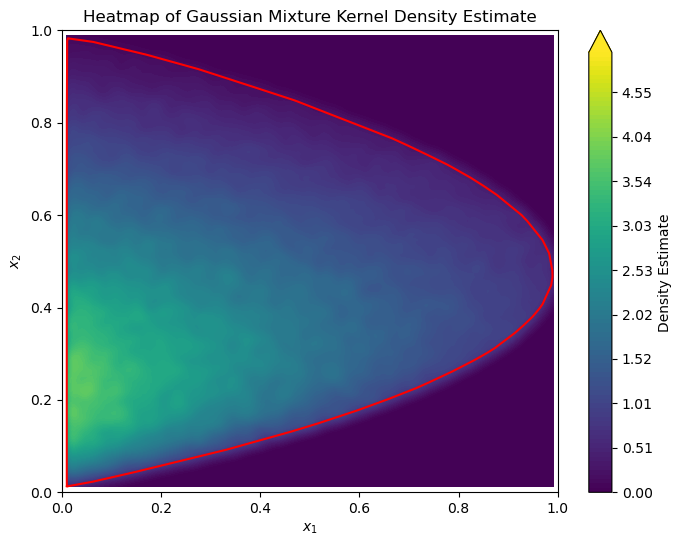

938

In [8]:
levels = np.linspace(color_level_min, color_level_max, 100)  # for 30 intervals

plt.figure(figsize=(8, 6))
cf = plt.contourf(
    grids[0],
    grids[1],
    np.clip(kde_predicted_density,0,None),
    levels=levels,
    cmap="viridis",
    extend="max"
)
cbar = plt.colorbar(cf, format="%.2f")
cbar.set_label("Density Estimate")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim(xlims)
plt.ylim(ylims)
plt.title("Heatmap of Gaussian Mixture Kernel Density Estimate")
# plt.plot(*boundary_polygon.exterior.xy)
plt.plot(*boundary_polygon.exterior.xy, color='red')
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

In [9]:
density_scale_factor = np.loadtxt("data/processed_data/muon_decay_scale_factor.txt")
print(f"scale factor: {density_scale_factor}")
print(f"max kde density: {np.max(kde_predicted_density)}, min kde density: {np.min(kde_predicted_density)}")
kde_predicted_density_scaled = kde_predicted_density * density_scale_factor
print(f"max scaled kde density: {np.max(kde_predicted_density_scaled)}, min scaled kde density: {np.min(kde_predicted_density_scaled)}")
data_in_pipeline = np.loadtxt('data/processed_data/muon_decay_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
print(f"max data in pipeline: {np.max(data_in_pipeline[:,2])}, min data in pipeline: {np.min(data_in_pipeline[:,2])}")


scale factor: 2.6967520737665374
max kde density: 3.7724693805723324, min kde density: -1.12578016418973e-15
max scaled kde density: 10.173414625279202, min scaled kde density: -3.0359499923838875e-15
max data in pipeline: 10.170818848849345, min data in pipeline: 0.23130696313233667


# Results

In [10]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [11]:
file_path = "data/pareto_results/muon_decay_results.py"
exec(open(file_path).read())

Original at complexity 1: 4.031955709008484
function_ready: 4.031955709008484
Processed: 4.00000000000000
LaTeX: 4.0

Original at complexity 3: 4.5248664081914525 - x2
function_ready: 4.5248664081914525 - x2
Processed: 4.5 - x2
LaTeX: 4.5 - x_{2}

Original at complexity 4: pow3(2.0511136840333504 - x2)
function_ready: pow3(2.0511136840333504 - x2)
Processed: pow3(2.1 - x2)
LaTeX: 9.3 \left(1 - 0.48 x_{2}\right)^{3}

Original at complexity 5: pow3(1.8557421747693326 - pow2(x2))
function_ready: pow3(1.8557421747693326 - pow2(x2))
Processed: pow3(1.9 - pow2(x2))
LaTeX: 6.9 \left(1 - 0.53 x_{2}^{2}\right)^{3}

Original at complexity 6: pow2((x1 - 2.899008495207475) + x2)
function_ready: pow2((x1 - 2.899008495207475) + x2)
Processed: pow2(x1 + x2 - 2.9)
LaTeX: 8.4 \left(0.34 x_{1} + 0.34 x_{2} - 1\right)^{2}

Original at complexity 7: 8.555782305258365 - pow2(exp(x2) + x1)
function_ready: 8.555782305258365 - pow2(np.exp(x2) + x1)
Processed: 8.6 - pow2(x1 + exp(x2))
LaTeX: 8.6 - \left(x_{1} 

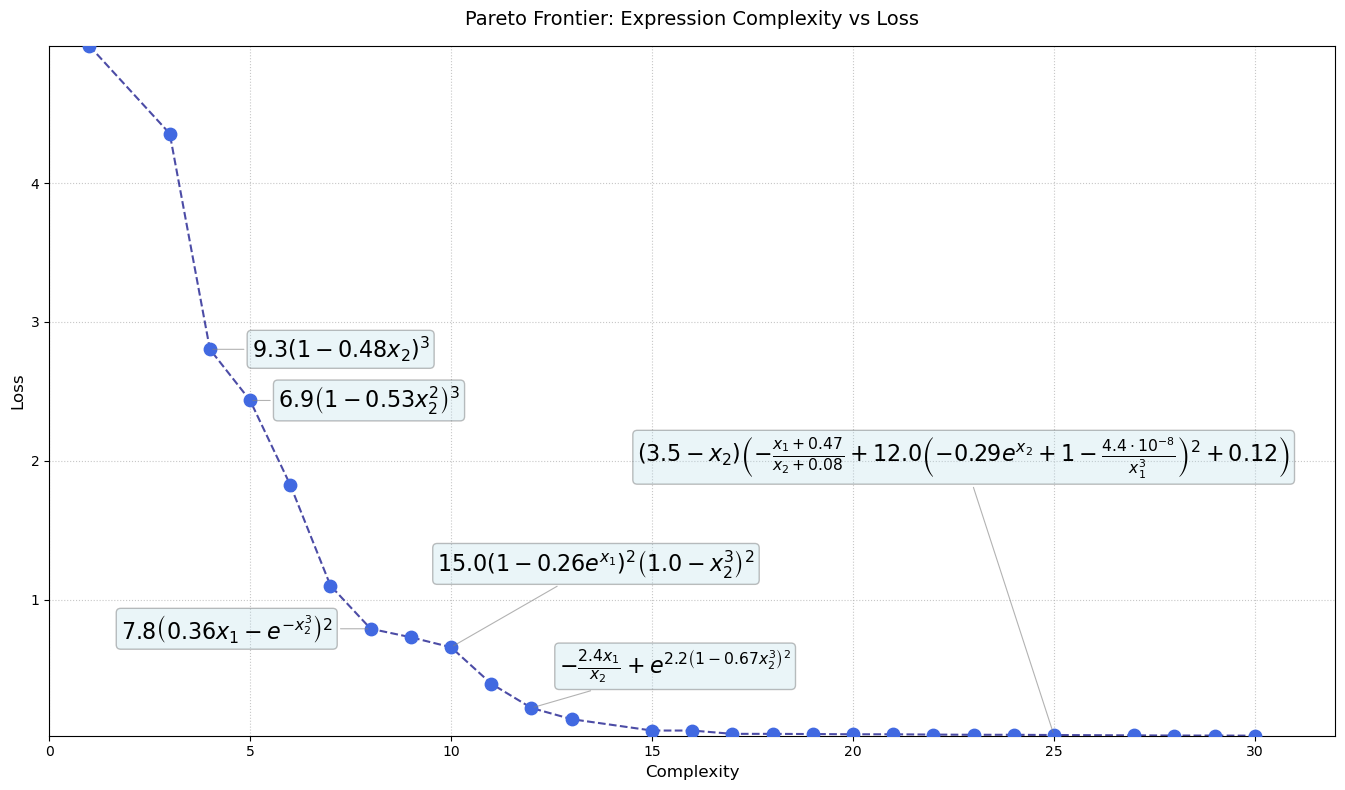

10041

In [19]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2 = sp.symbols('x1 x2')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (30, 0), (20, 0), (-180, 0),
    (-80, 0), (-180, 0), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-300, 200), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [3-1, 4-1, 7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

# Residuals: Prediction - Ground Truth

In [13]:
level_min = 0
level_max = 5
level_min_delta = -1
level_max_delta = 1

In [26]:
predicted_functions = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]
masked_functions = [
    (lambda f: lambda x1, x2, mask: np.where(mask, 0, f(x1, x2)))(f)
    for f in predicted_functions
]
mask = np.array([boundary_polygon.contains(Point(p)) for p in grid_coordinates]).reshape(np.shape(grids[0]))
mask = ~mask

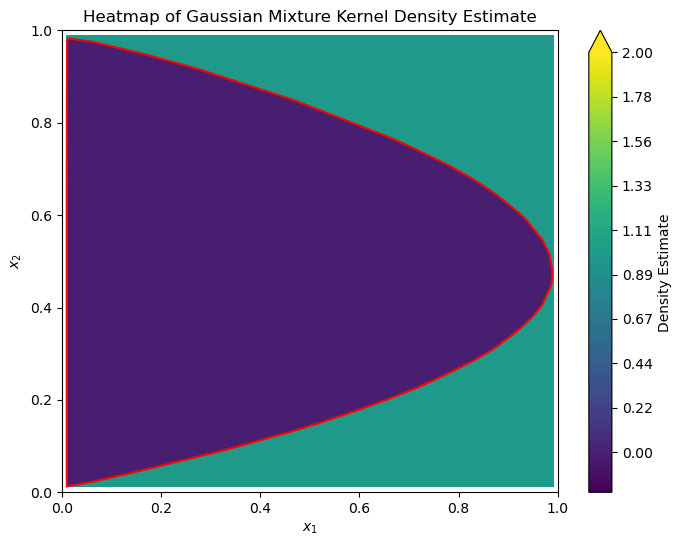

6652

In [27]:
levels = np.linspace(-0.2, 2, 100)  # for 30 intervals

plt.figure(figsize=(8, 6))
cf = plt.contourf(
    grids[0],
    grids[1],
    mask,
    levels=levels,
    cmap="viridis",
    extend="max"
)
cbar = plt.colorbar(cf, format="%.2f")
cbar.set_label("Density Estimate")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim(xlims)
plt.ylim(ylims)
plt.title("Heatmap of Gaussian Mixture Kernel Density Estimate")
# plt.plot(*boundary_polygon.exterior.xy)
plt.plot(*boundary_polygon.exterior.xy, color='red')
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

In [28]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    kde_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

# Load the test set for the Gaussian mixture
test_samples = np.loadtxt("./data/processed_data/muon_decay_test_samples.csv", delimiter=",")
test_samples = test_samples[test_samples[:,0]>0.01]
test_samples = test_samples[test_samples[:,0]<0.99]
test_samples = test_samples[test_samples[:,1]>0.01]
test_samples = test_samples[test_samples[:,1]<0.99]

# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-12))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")

Likelihood score of the corrected KDE: 26,762.04133809931


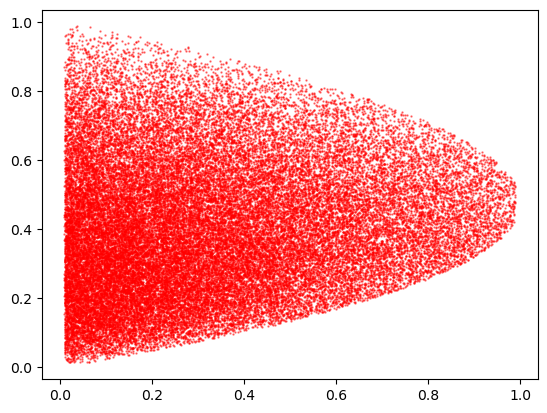

3093

In [16]:
plt.scatter(test_samples[:,0], test_samples[:,1], s=0.5, alpha=0.5, label='Data Points', color='red')
plt.show()
plt.close() 
gc.collect()

In [29]:
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-130))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}\n")

for idx, func in enumerate(predicted_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(test_samples[:, 0], test_samples[:, 1])
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

Likelihood score of the corrected KDE: 26,762.04133806572

Function at complexity 1: Likelihood score = 0.4022034325800556
Function at complexity 3: Likelihood score = 20,626.315907707452
Function at complexity 4: Likelihood score = 23,342.022638784896
Function at complexity 5: Likelihood score = 24,377.53577269893
Function at complexity 6: Likelihood score = 25,430.811107779435
Function at complexity 7: Likelihood score = 25,915.459861773554
Function at complexity 8: Likelihood score = 27,299.919012962746
Function at complexity 9: Likelihood score = 27,558.52169613401
Function at complexity 10: Likelihood score = 26,118.49785301851
Function at complexity 11: Likelihood score = 26,660.753366141
Function at complexity 12: Likelihood score = nan
Function at complexity 13: Likelihood score = nan
Function at complexity 15: Likelihood score = 26,962.127306434126
Function at complexity 16: Likelihood score = 27,054.77310165962
Function at complexity 17: Likelihood score = nan
Function at com

/tmp/ipykernel_2887550/197600433.py:8: RuntimeWarning: invalid value encountered in log
  likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)


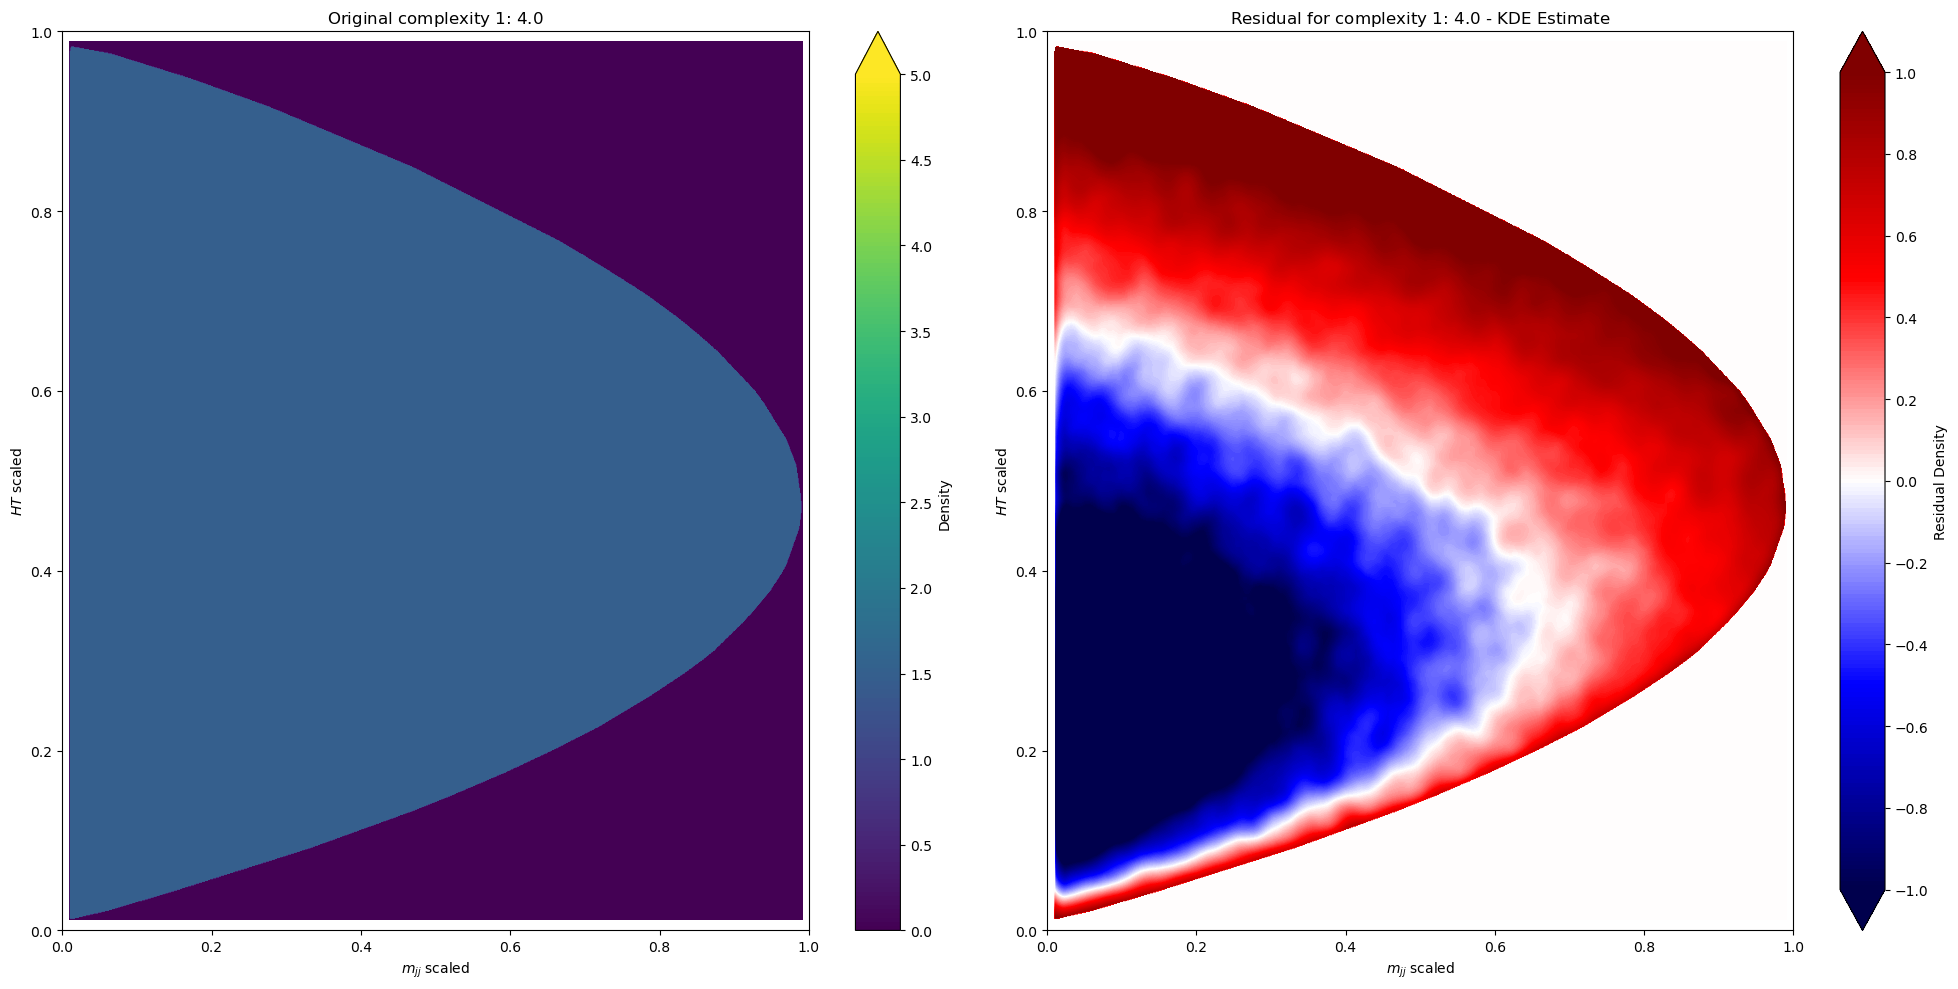

Complexity 1: Likelihood score: 19,655.27954672205
complexity 1 :: min predict: 0.00, max predict: 1.50
complexity 1 :: min residual: -2.28, max residual: 1.40
Complexity 1: MSE error: 3.341253e+00


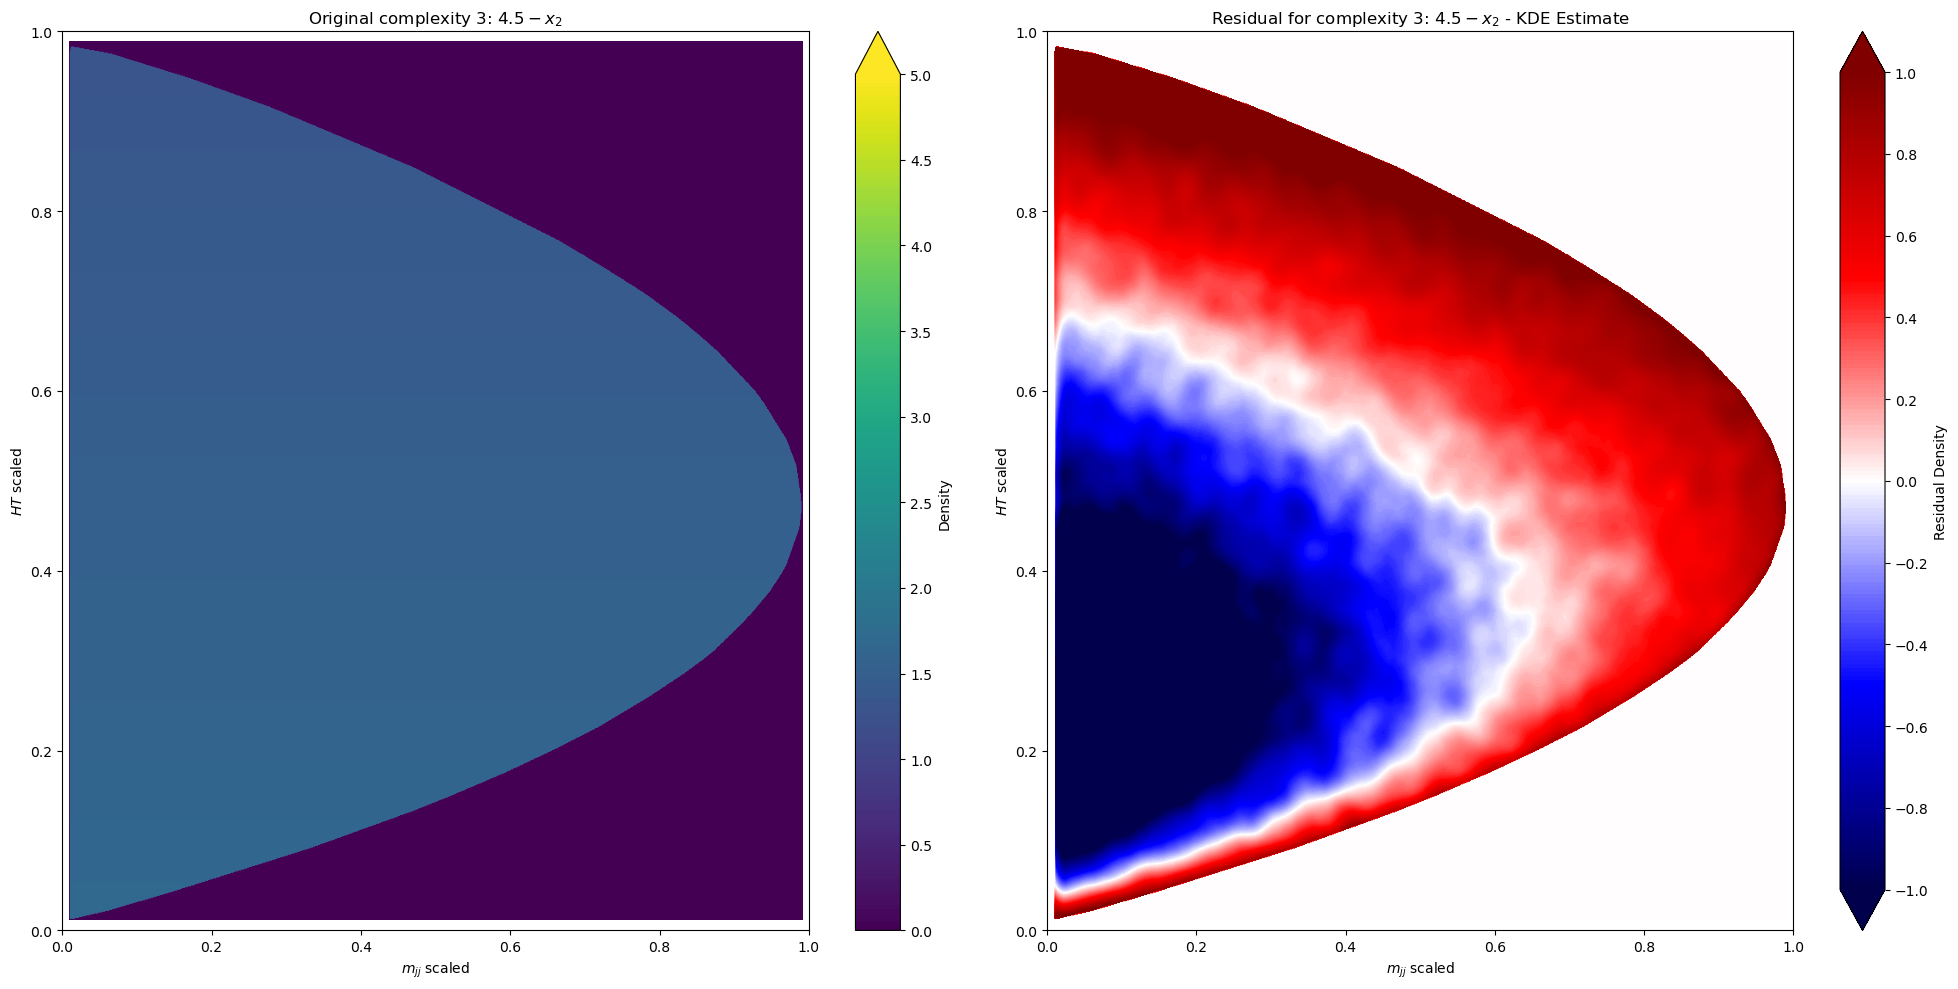

Complexity 3: Likelihood score: 20,626.315907675376
complexity 3 :: min predict: 0.00, max predict: 1.67
complexity 3 :: min residual: -2.18, max residual: 1.23
Complexity 3: MSE error: 2.919224e+00


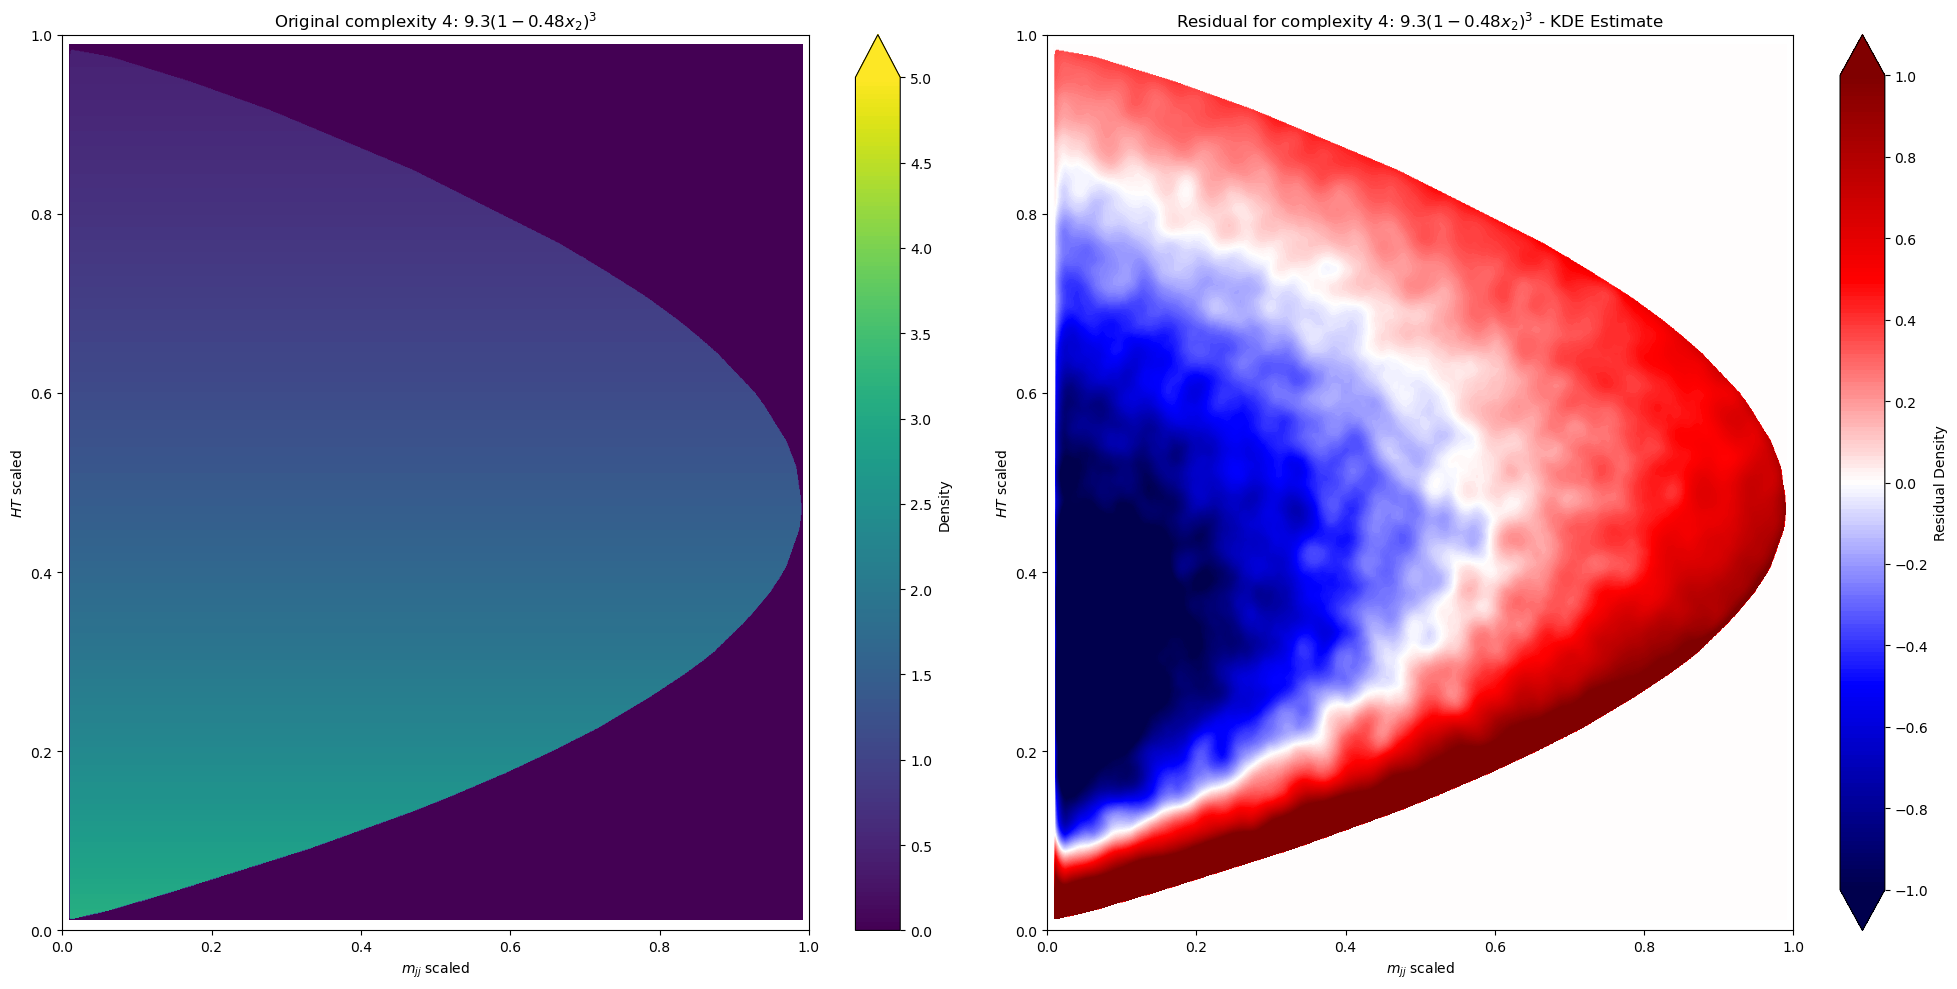

Complexity 4: Likelihood score: 23,342.022638752438
complexity 4 :: min predict: 0.00, max predict: 3.13
complexity 4 :: min residual: -1.70, max residual: 2.62
Complexity 4: MSE error: 1.885831e+00


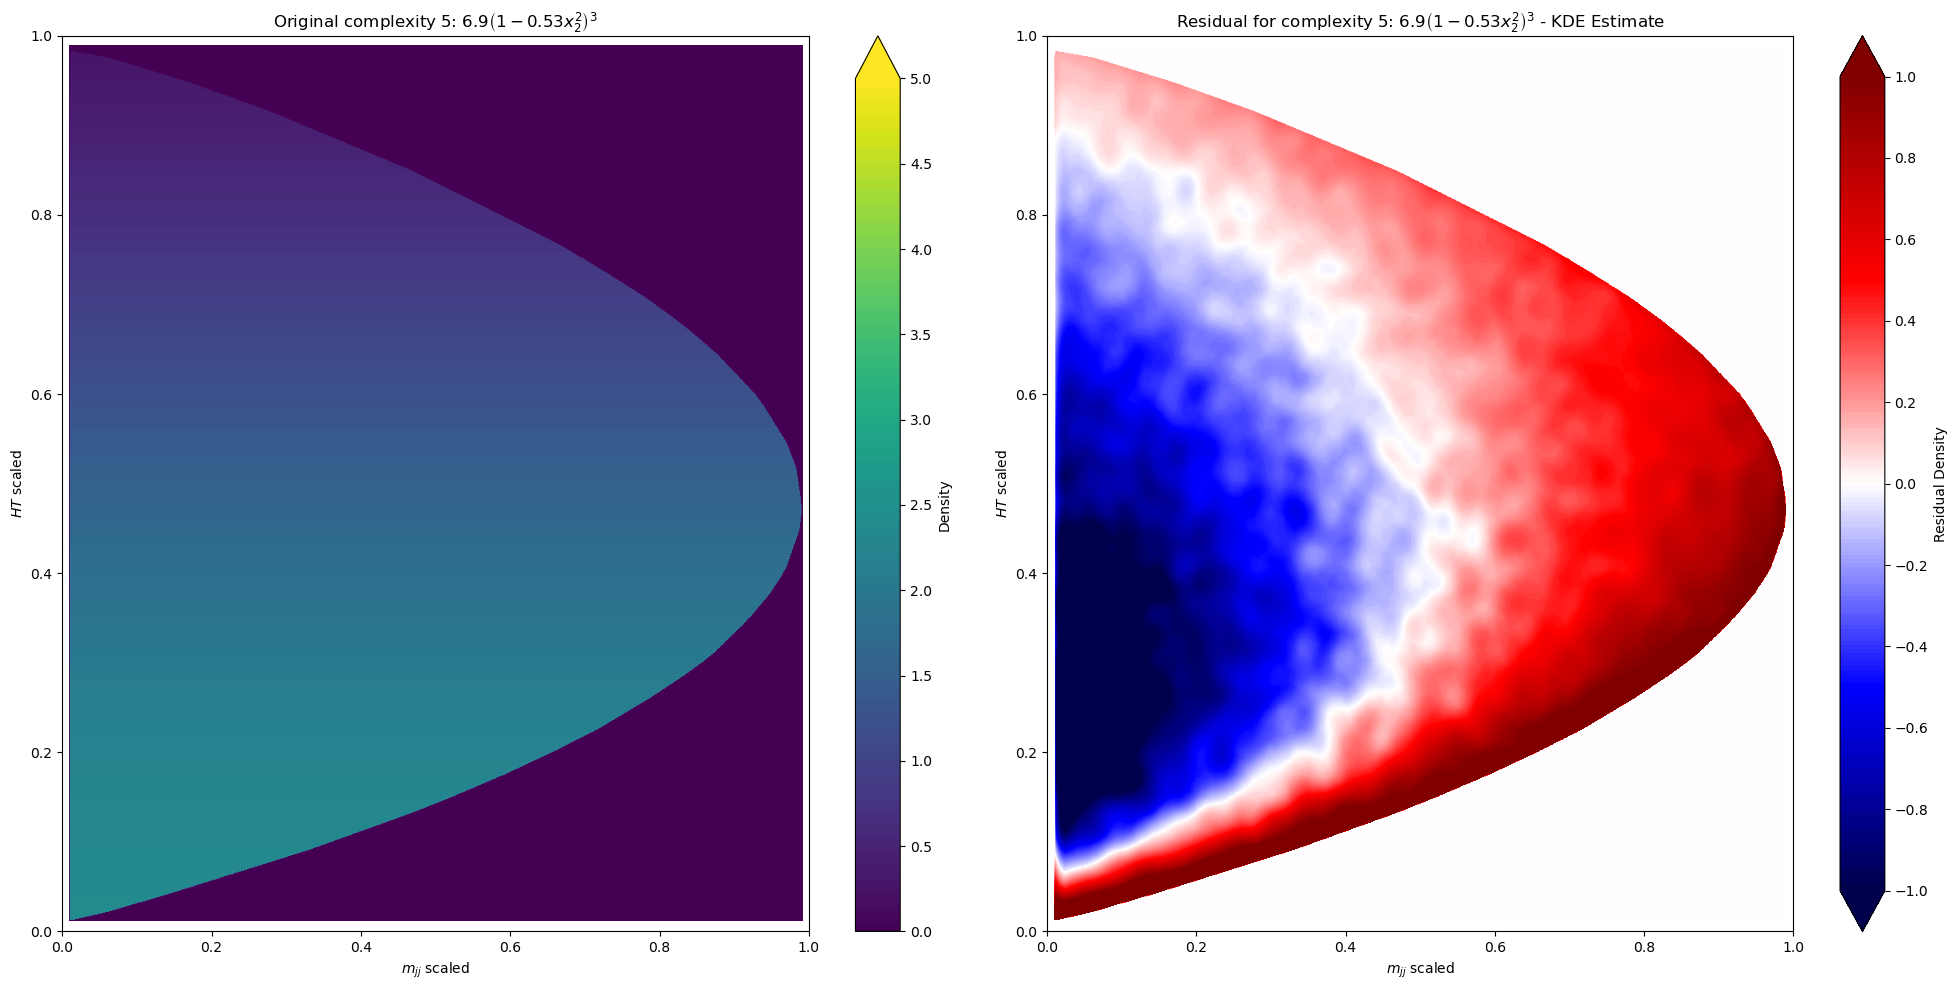

Complexity 5: Likelihood score: 24,377.535772667143
complexity 5 :: min predict: 0.00, max predict: 2.37
complexity 5 :: min residual: -1.67, max residual: 1.86
Complexity 5: MSE error: 1.632583e+00


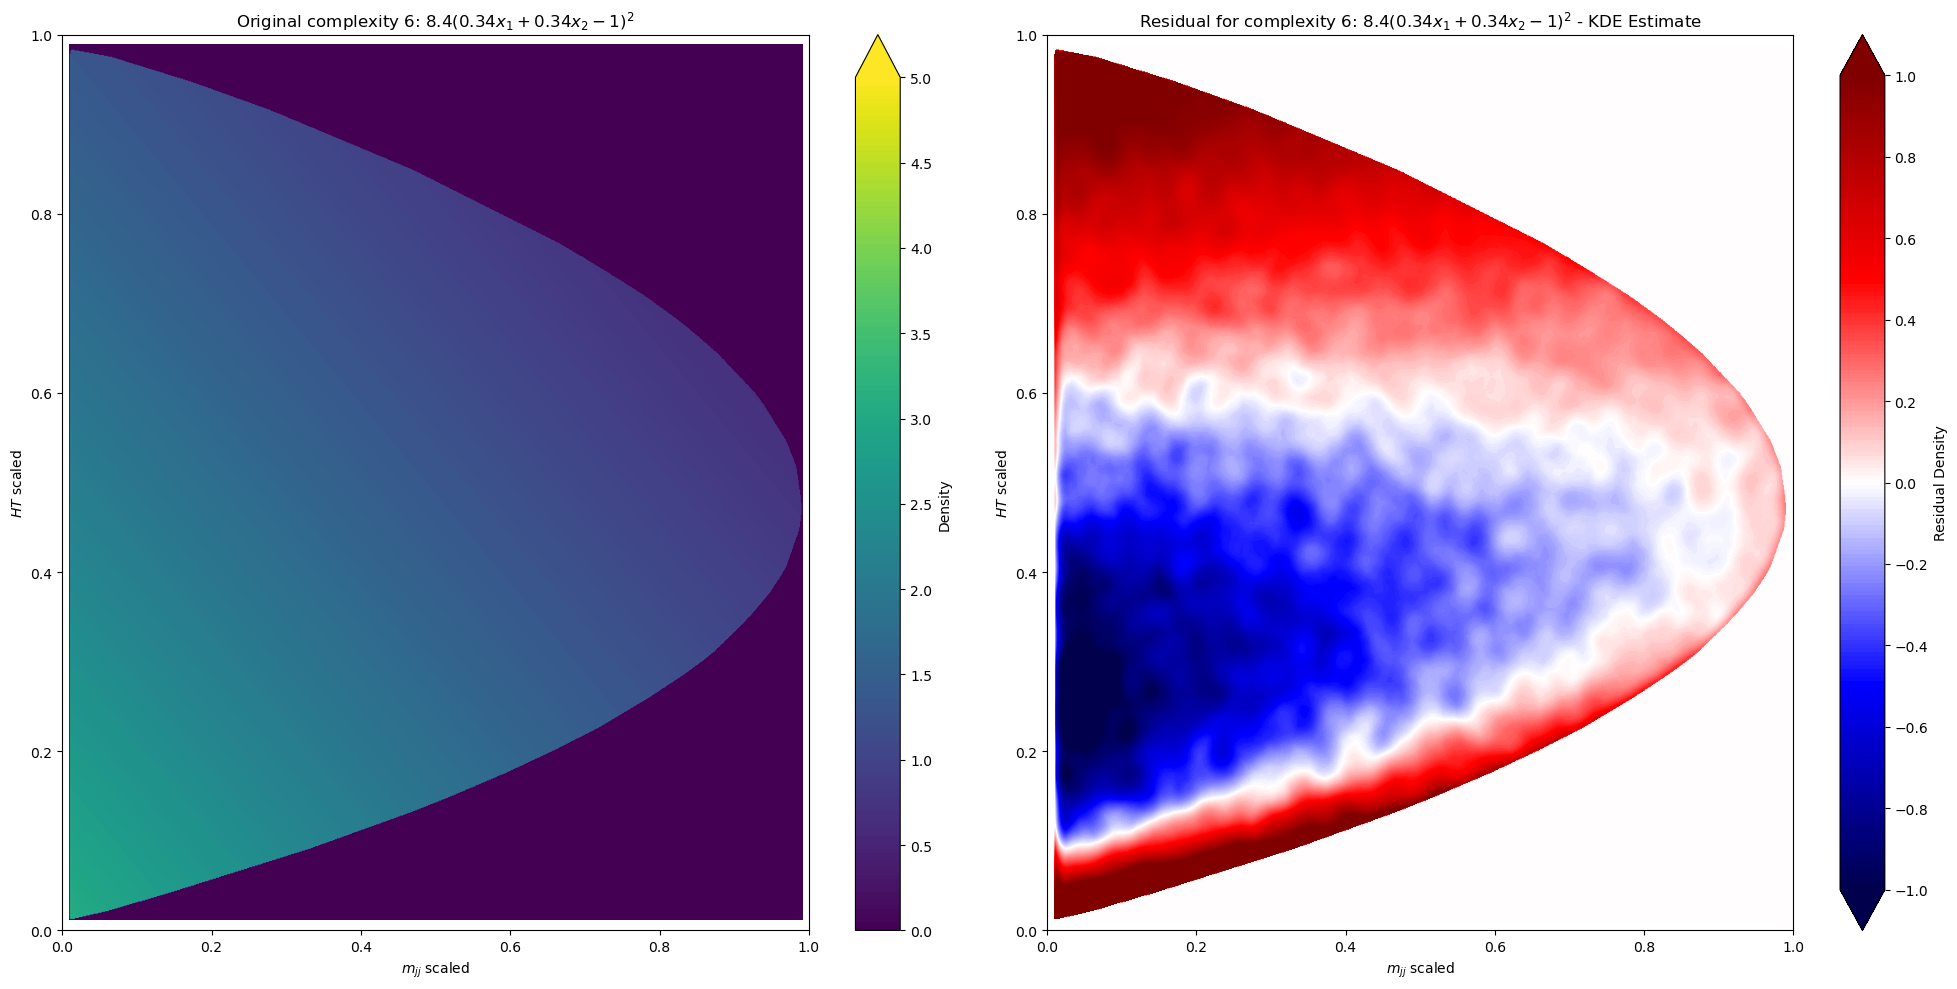

Complexity 6: Likelihood score: 25,430.811107748872
complexity 6 :: min predict: 0.00, max predict: 3.06
complexity 6 :: min residual: -1.26, max residual: 2.55
Complexity 6: MSE error: 1.232986e+00


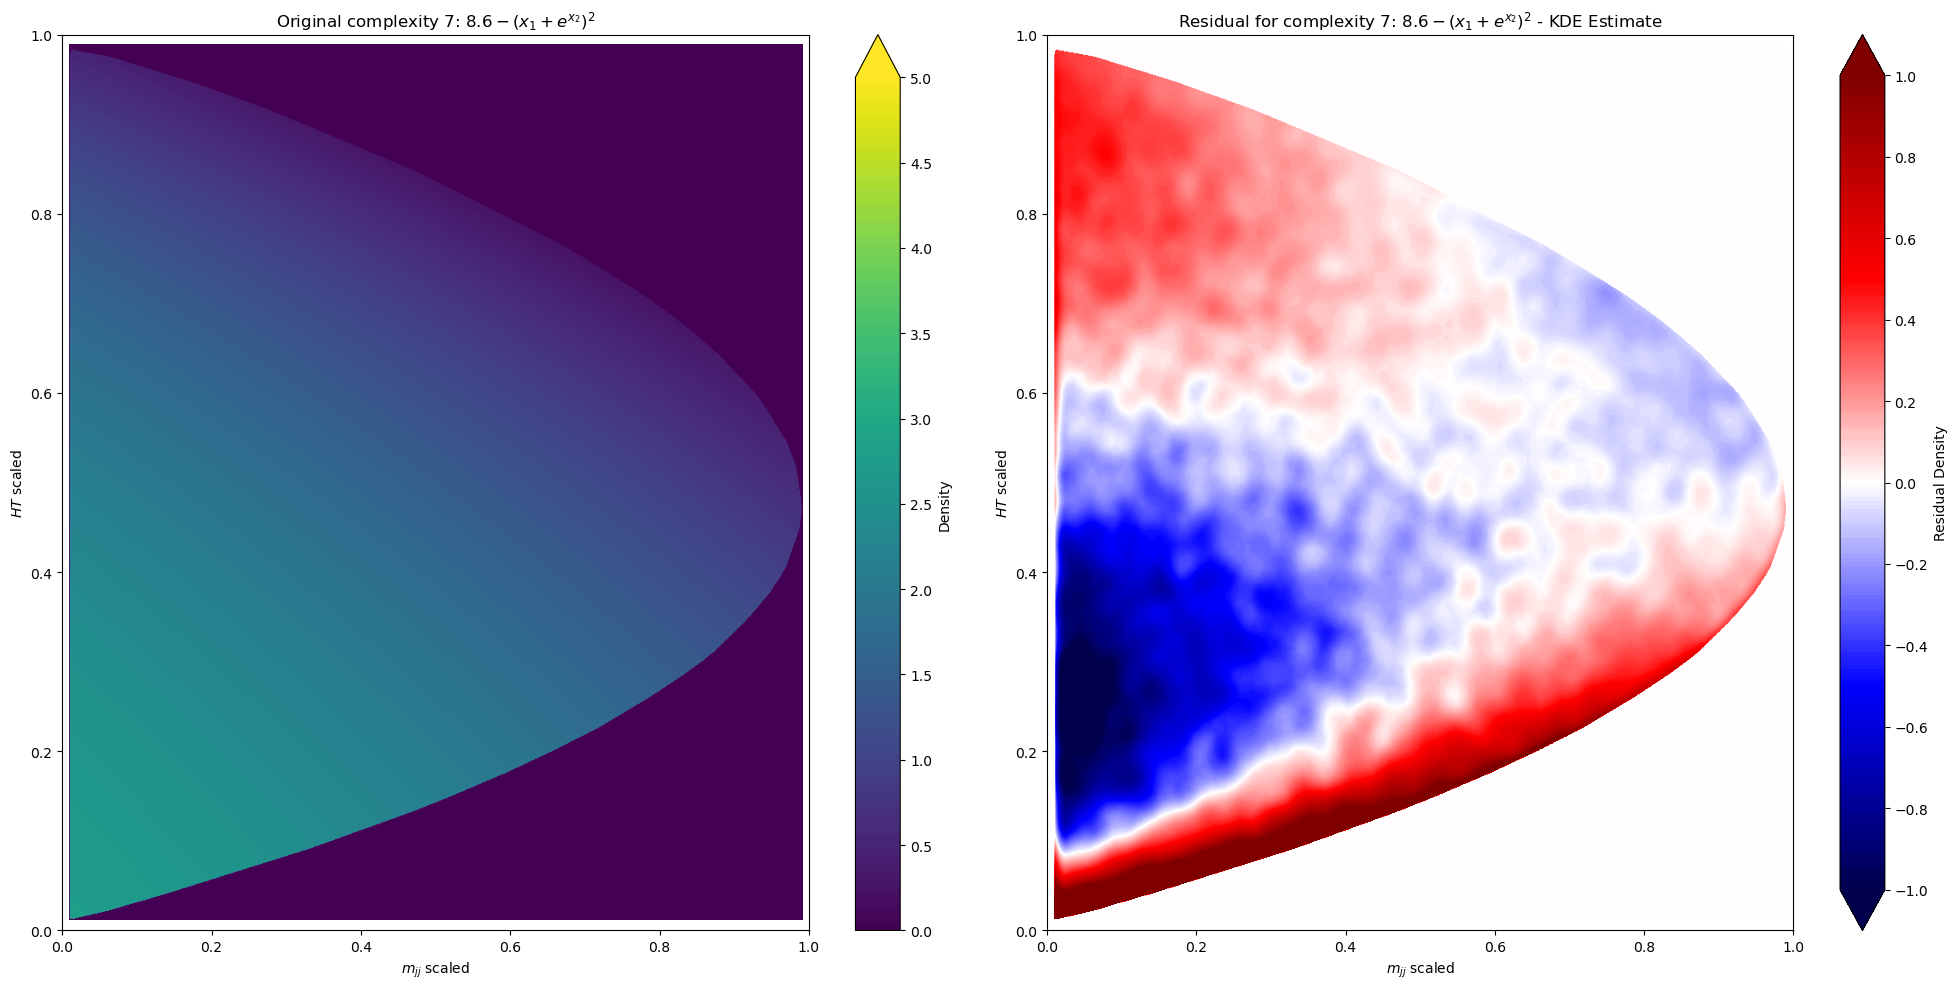

Complexity 7: Likelihood score: 25,915.45986174154
complexity 7 :: min predict: 0.00, max predict: 2.78
complexity 7 :: min residual: -1.25, max residual: 2.27
Complexity 7: MSE error: 7.457708e-01


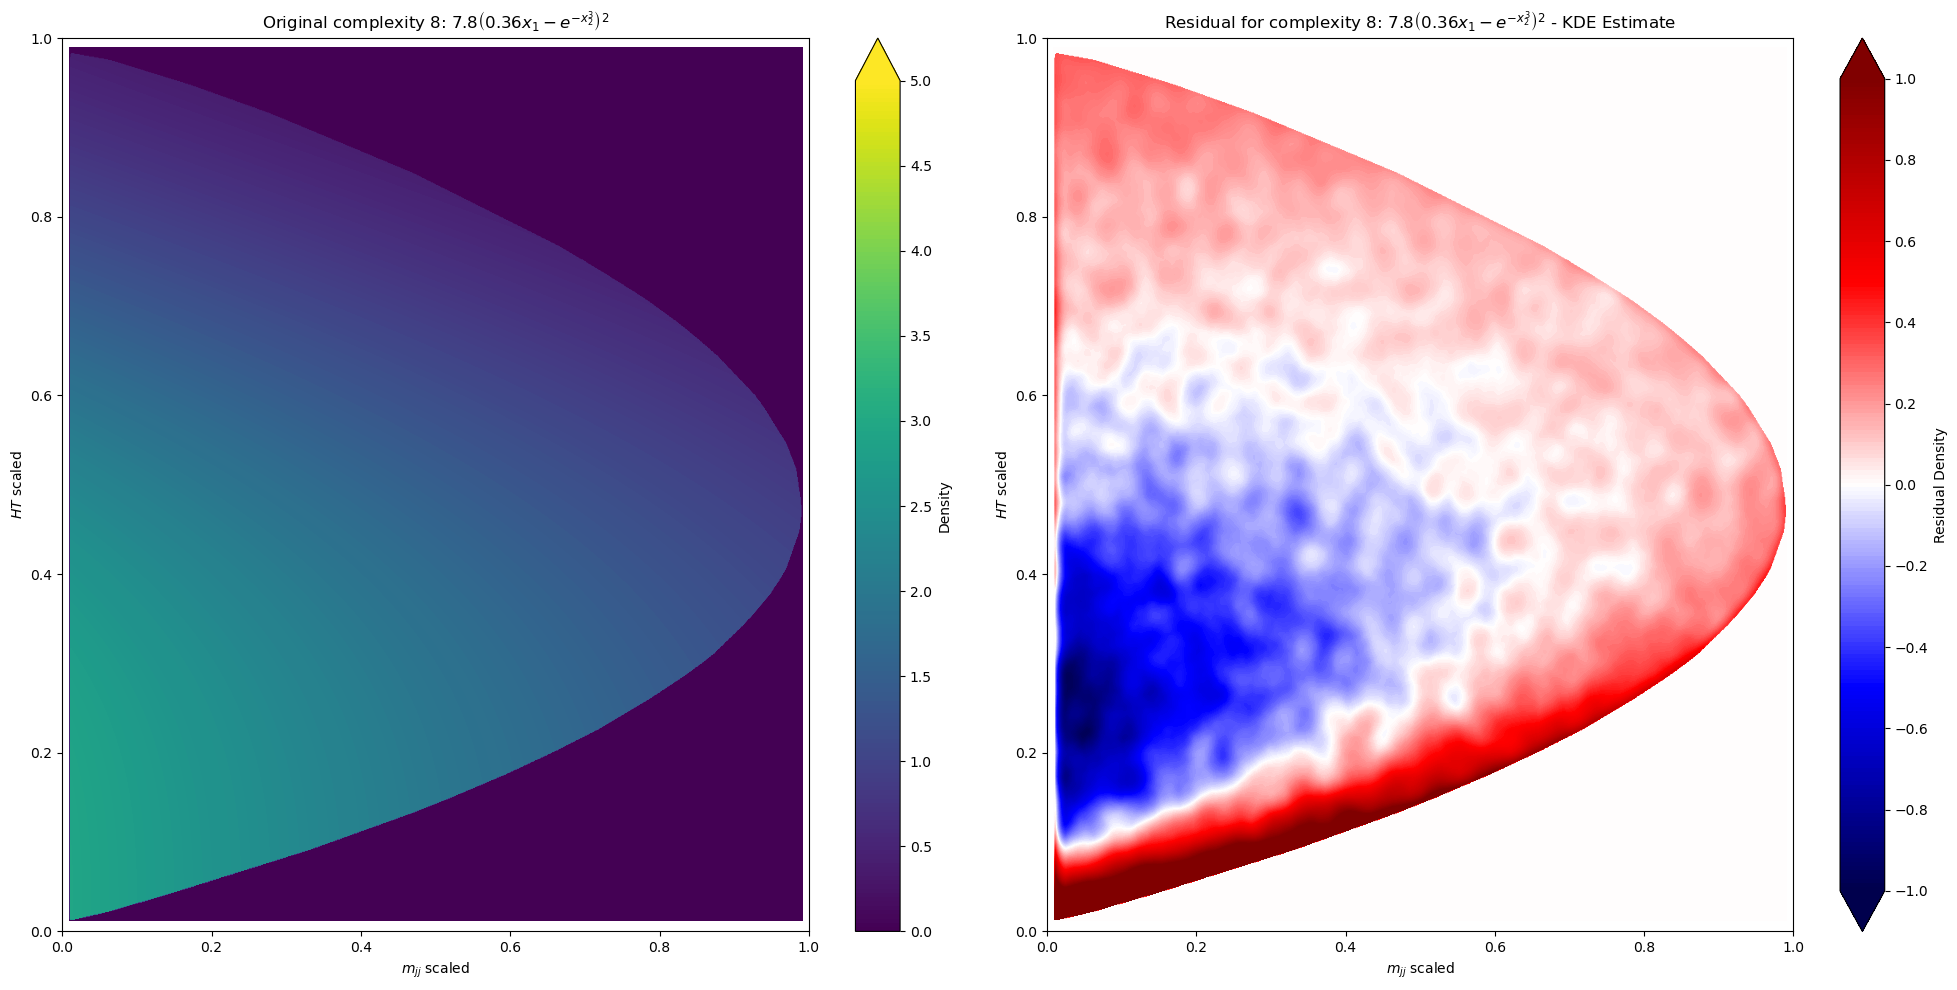

Complexity 8: Likelihood score: 27,299.9190129322
complexity 8 :: min predict: 0.00, max predict: 2.95
complexity 8 :: min residual: -0.97, max residual: 2.43
Complexity 8: MSE error: 5.352790e-01


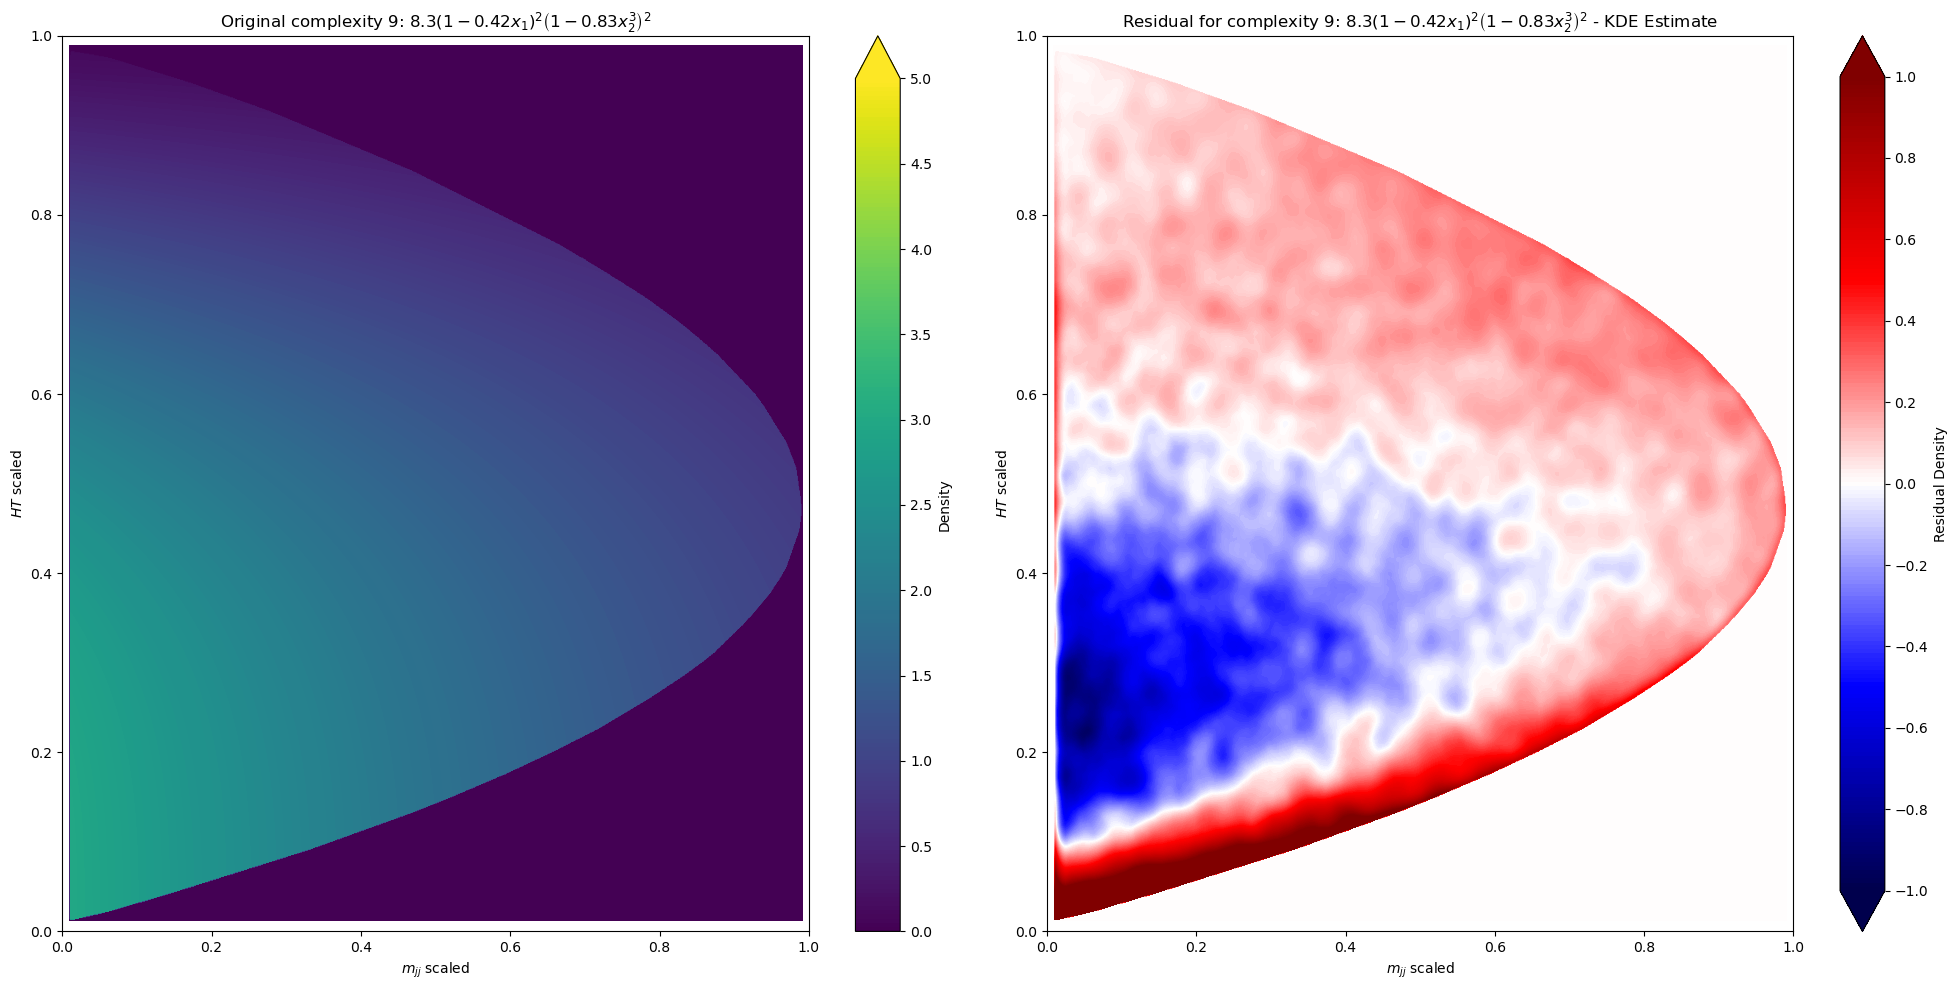

Complexity 9: Likelihood score: 27,558.521696103533
complexity 9 :: min predict: 0.00, max predict: 2.99
complexity 9 :: min residual: -0.94, max residual: 2.47
Complexity 9: MSE error: 4.926825e-01


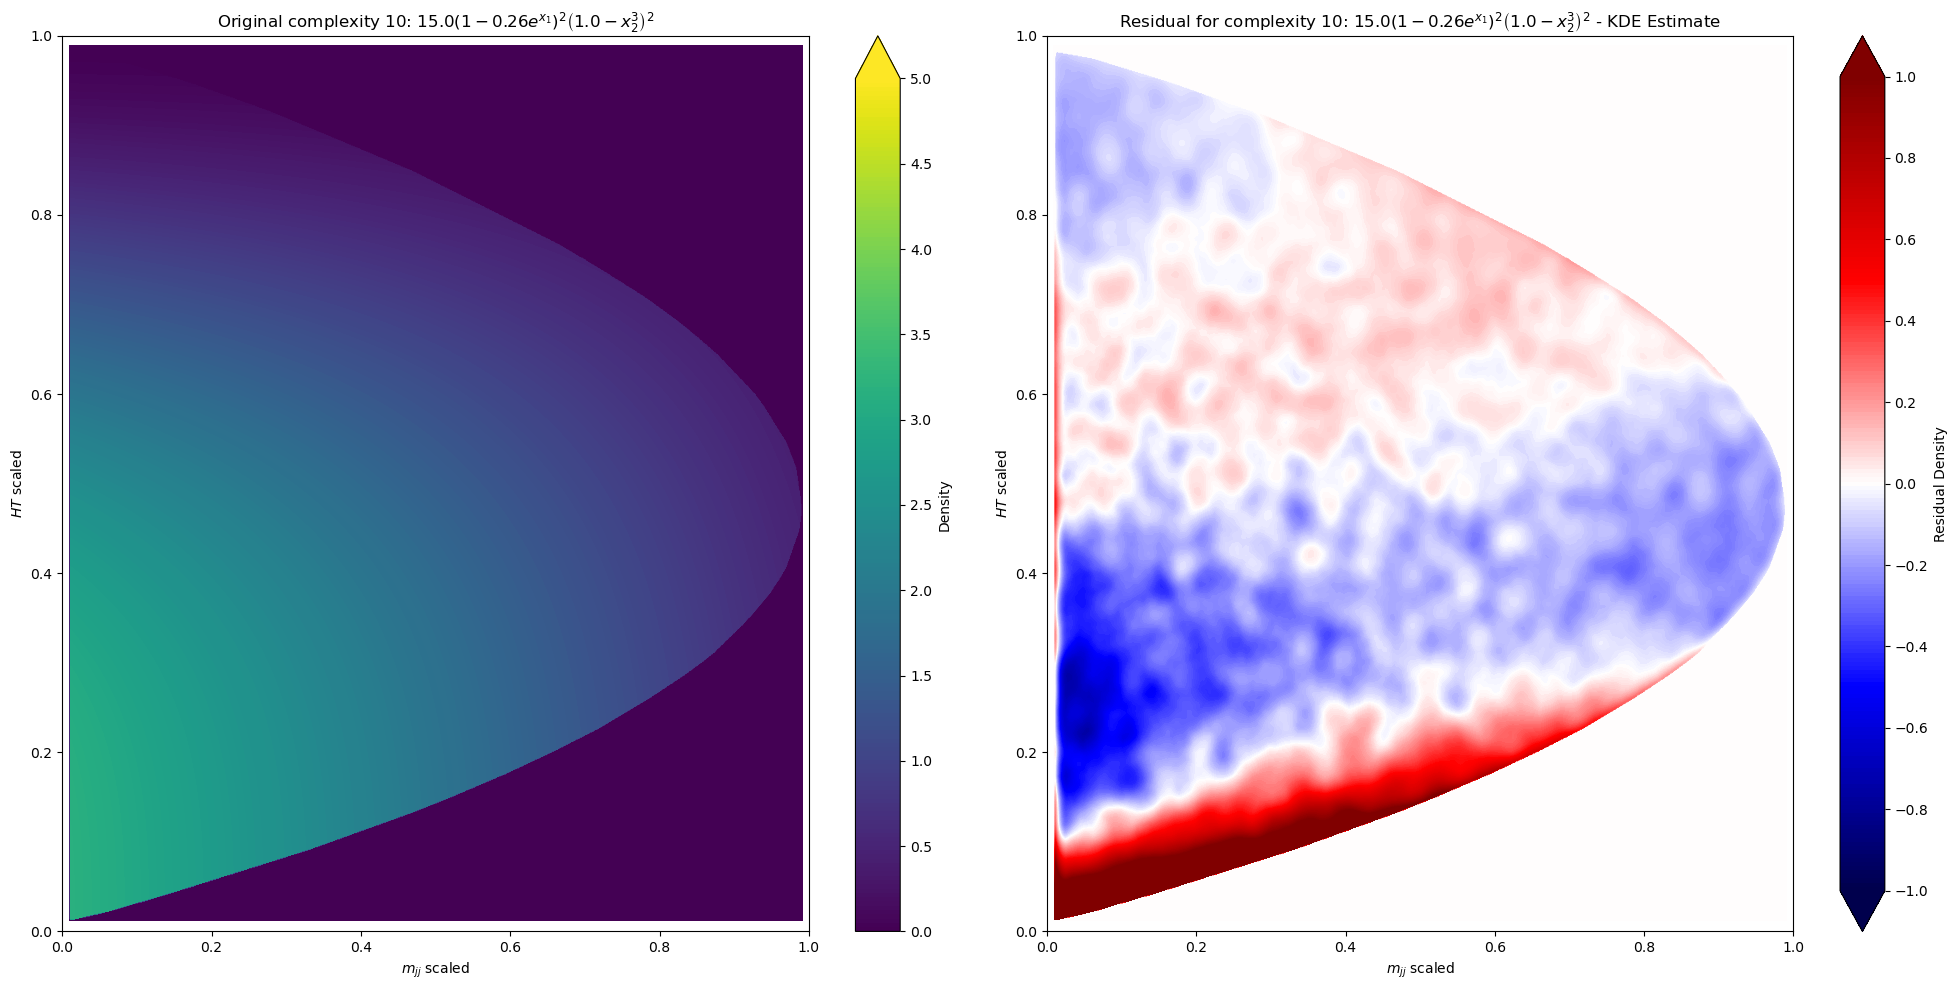

Complexity 10: Likelihood score: 26,118.49785298331
complexity 10 :: min predict: 0.00, max predict: 3.18
complexity 10 :: min residual: -0.75, max residual: 2.67
Complexity 10: MSE error: 4.435329e-01


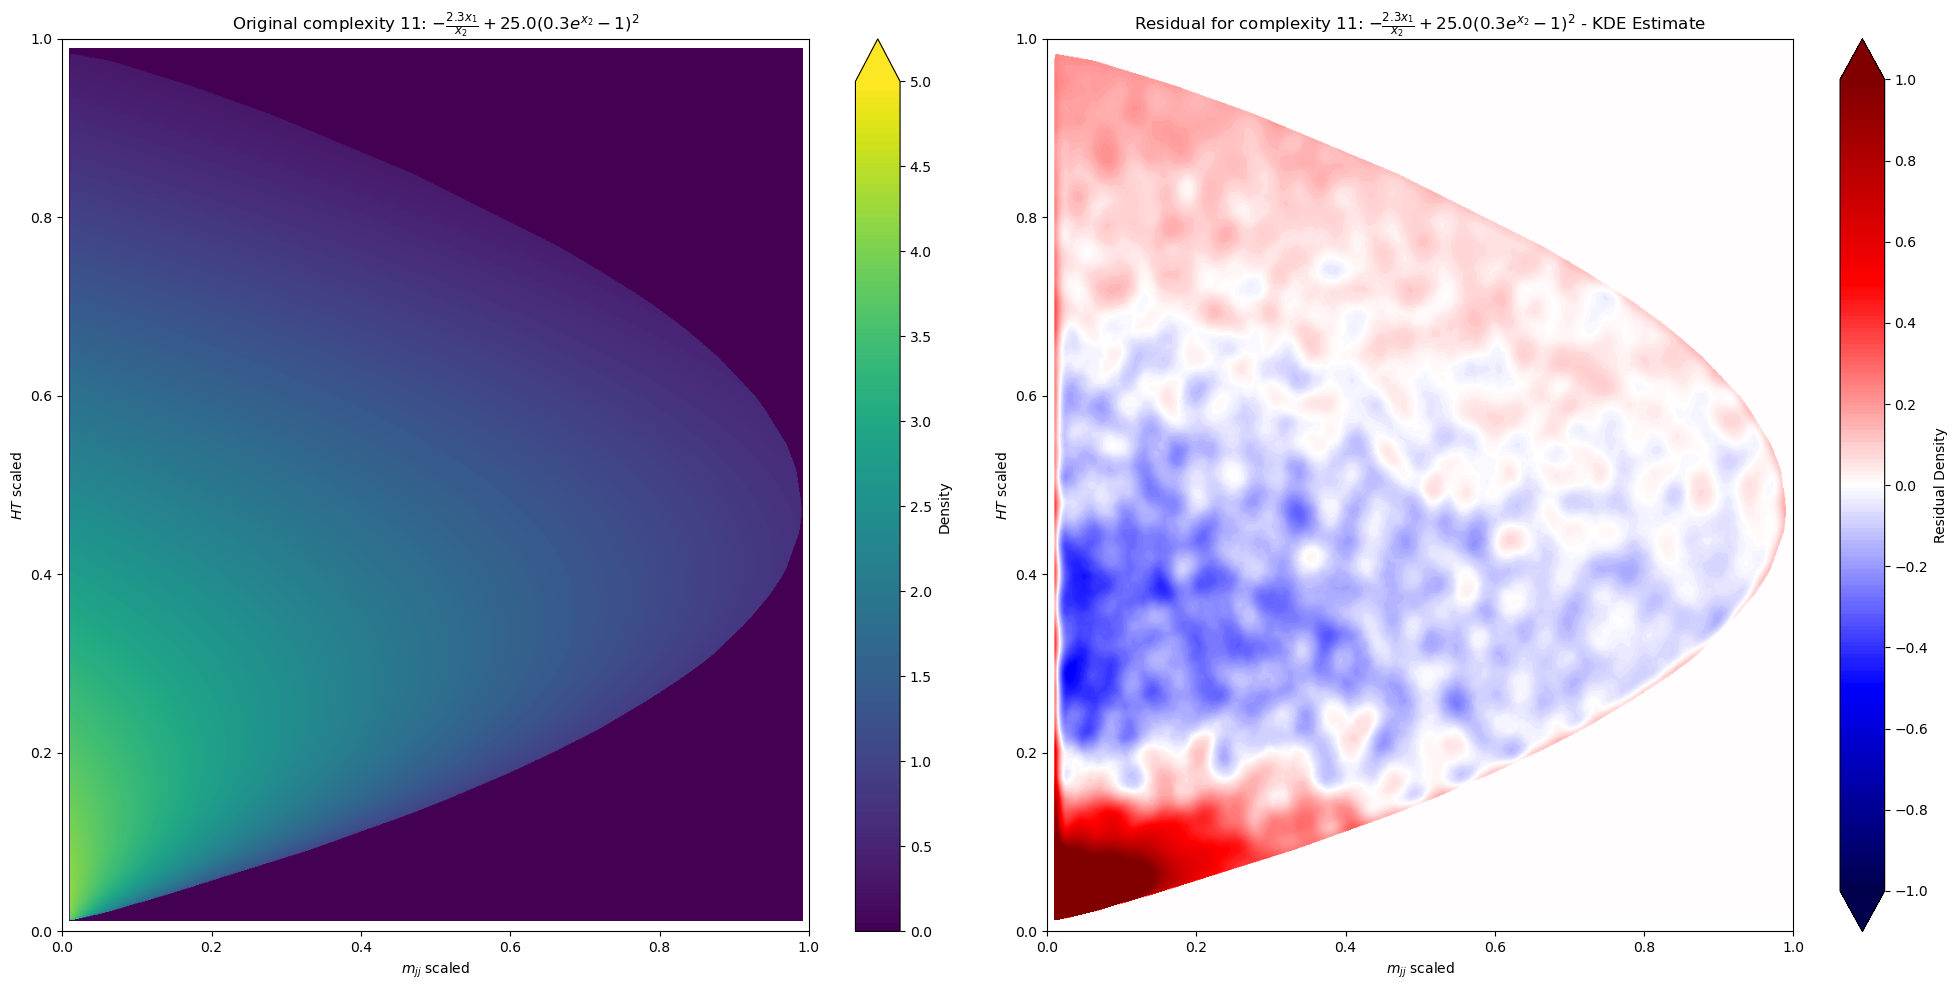

Complexity 11: Likelihood score: 26,660.7533661088
complexity 11 :: min predict: 0.00, max predict: 4.13
complexity 11 :: min residual: -0.51, max residual: 3.30
Complexity 11: MSE error: 2.635455e-01


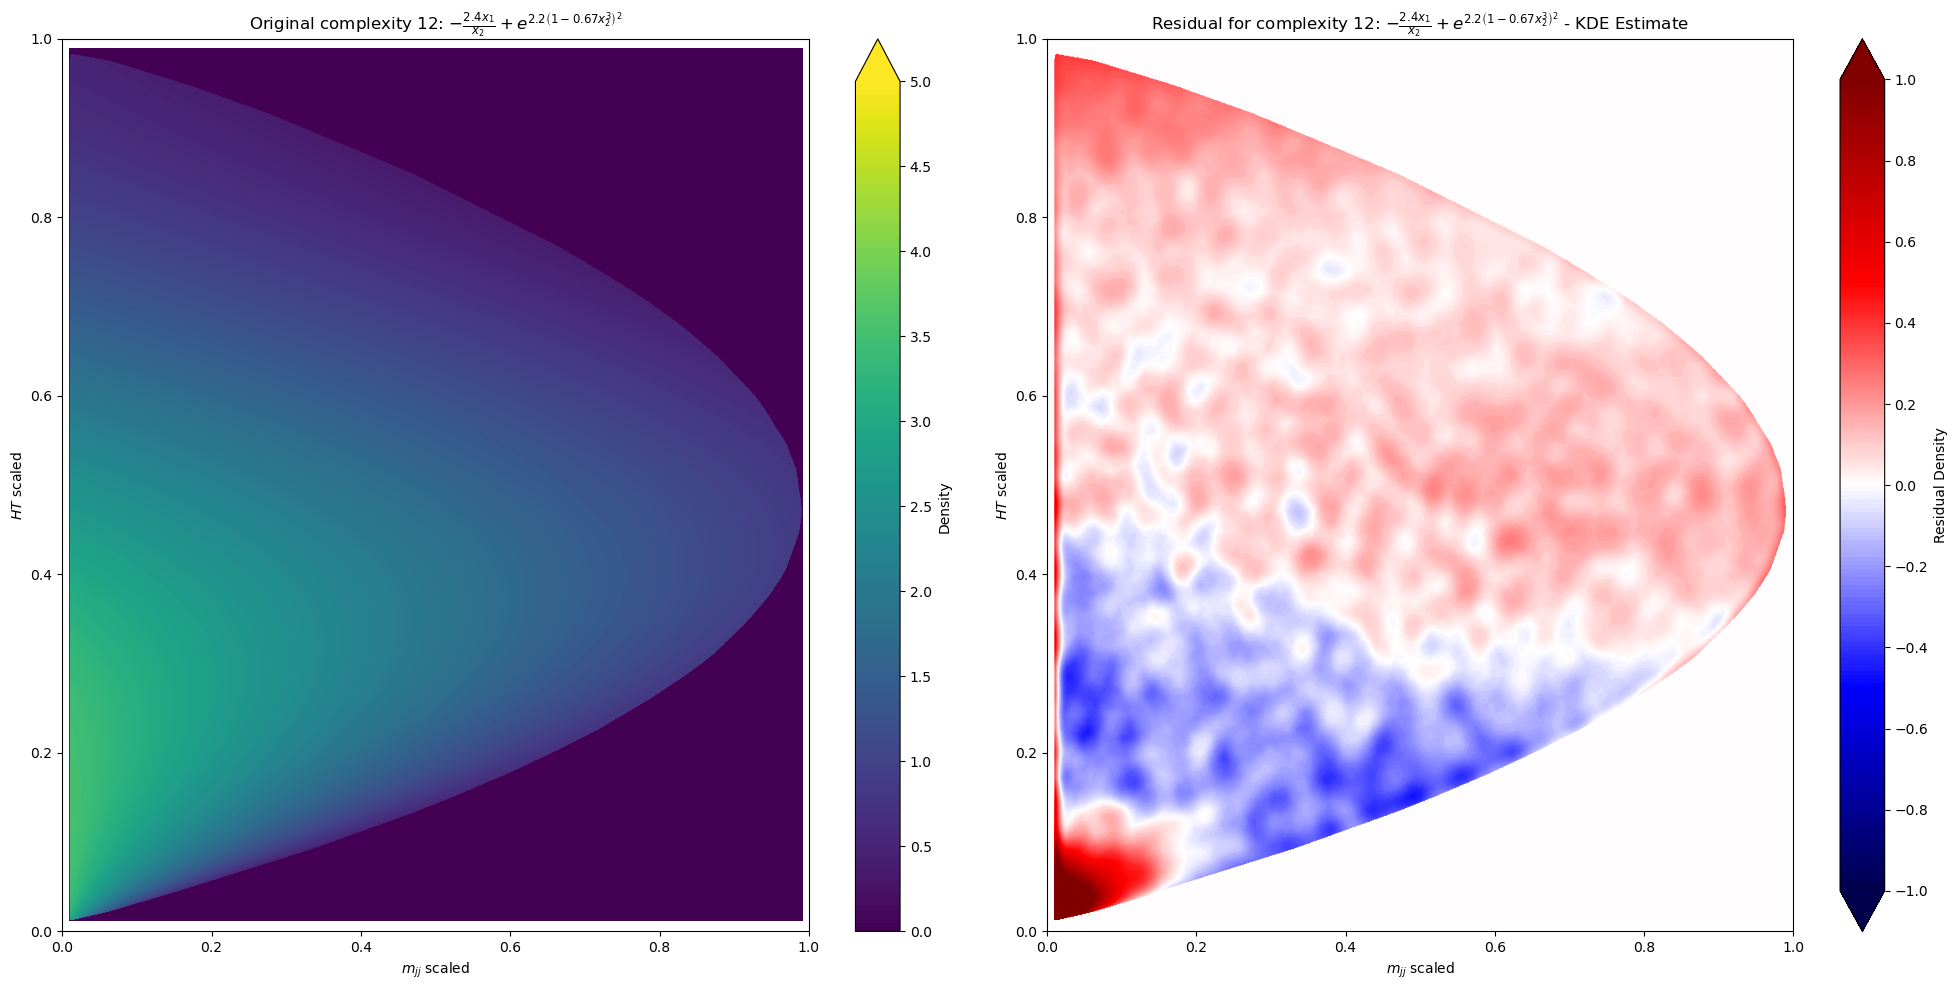

/tmp/ipykernel_2887550/3320636019.py:74: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


Complexity 12: Likelihood score: nan
complexity 12 :: min predict: 0.00, max predict: 3.55
complexity 12 :: min residual: -0.47, max residual: 2.47
Complexity 12: MSE error: 1.447414e-01


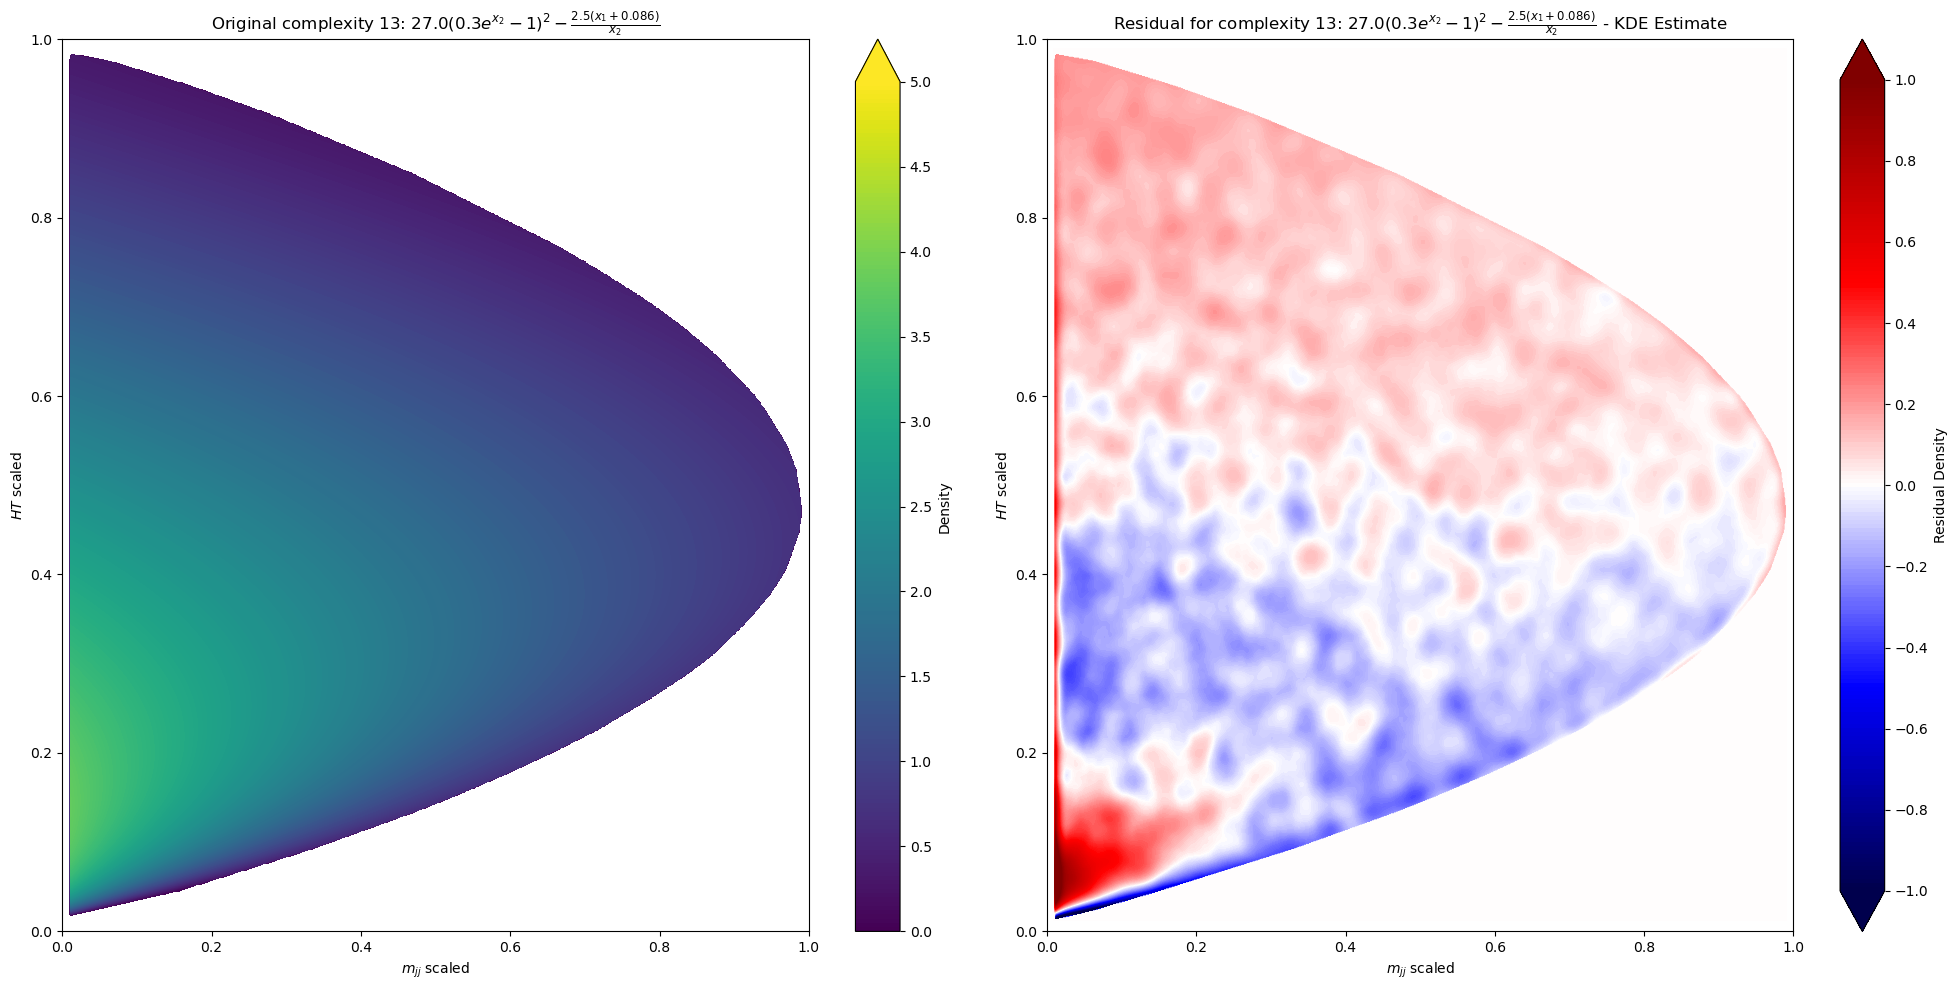

Complexity 13: Likelihood score: nan
complexity 13 :: min predict: -1.72, max predict: 3.80
complexity 13 :: min residual: -2.28, max residual: 1.39
Complexity 13: MSE error: 9.137585e-02


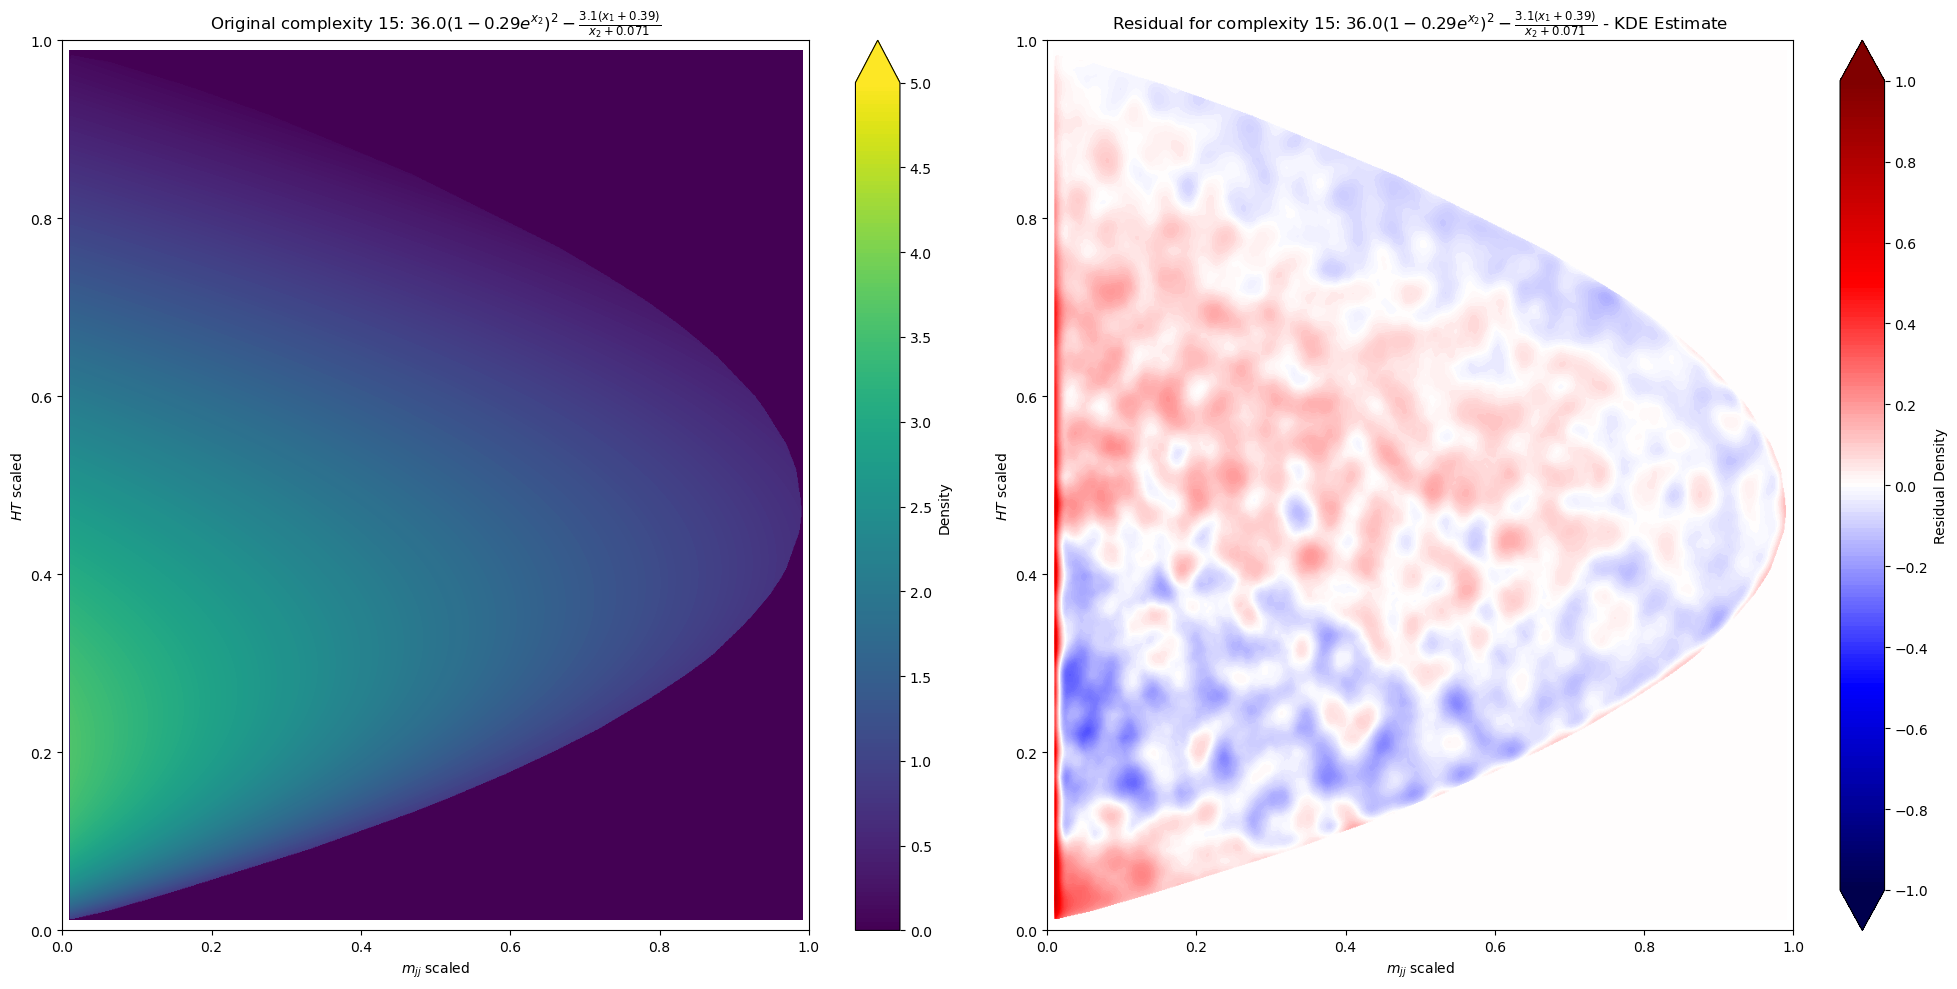

Complexity 15: Likelihood score: 26,962.12730640037
complexity 15 :: min predict: 0.00, max predict: 3.60
complexity 15 :: min residual: -0.34, max residual: 0.71
Complexity 15: MSE error: 3.600598e-02


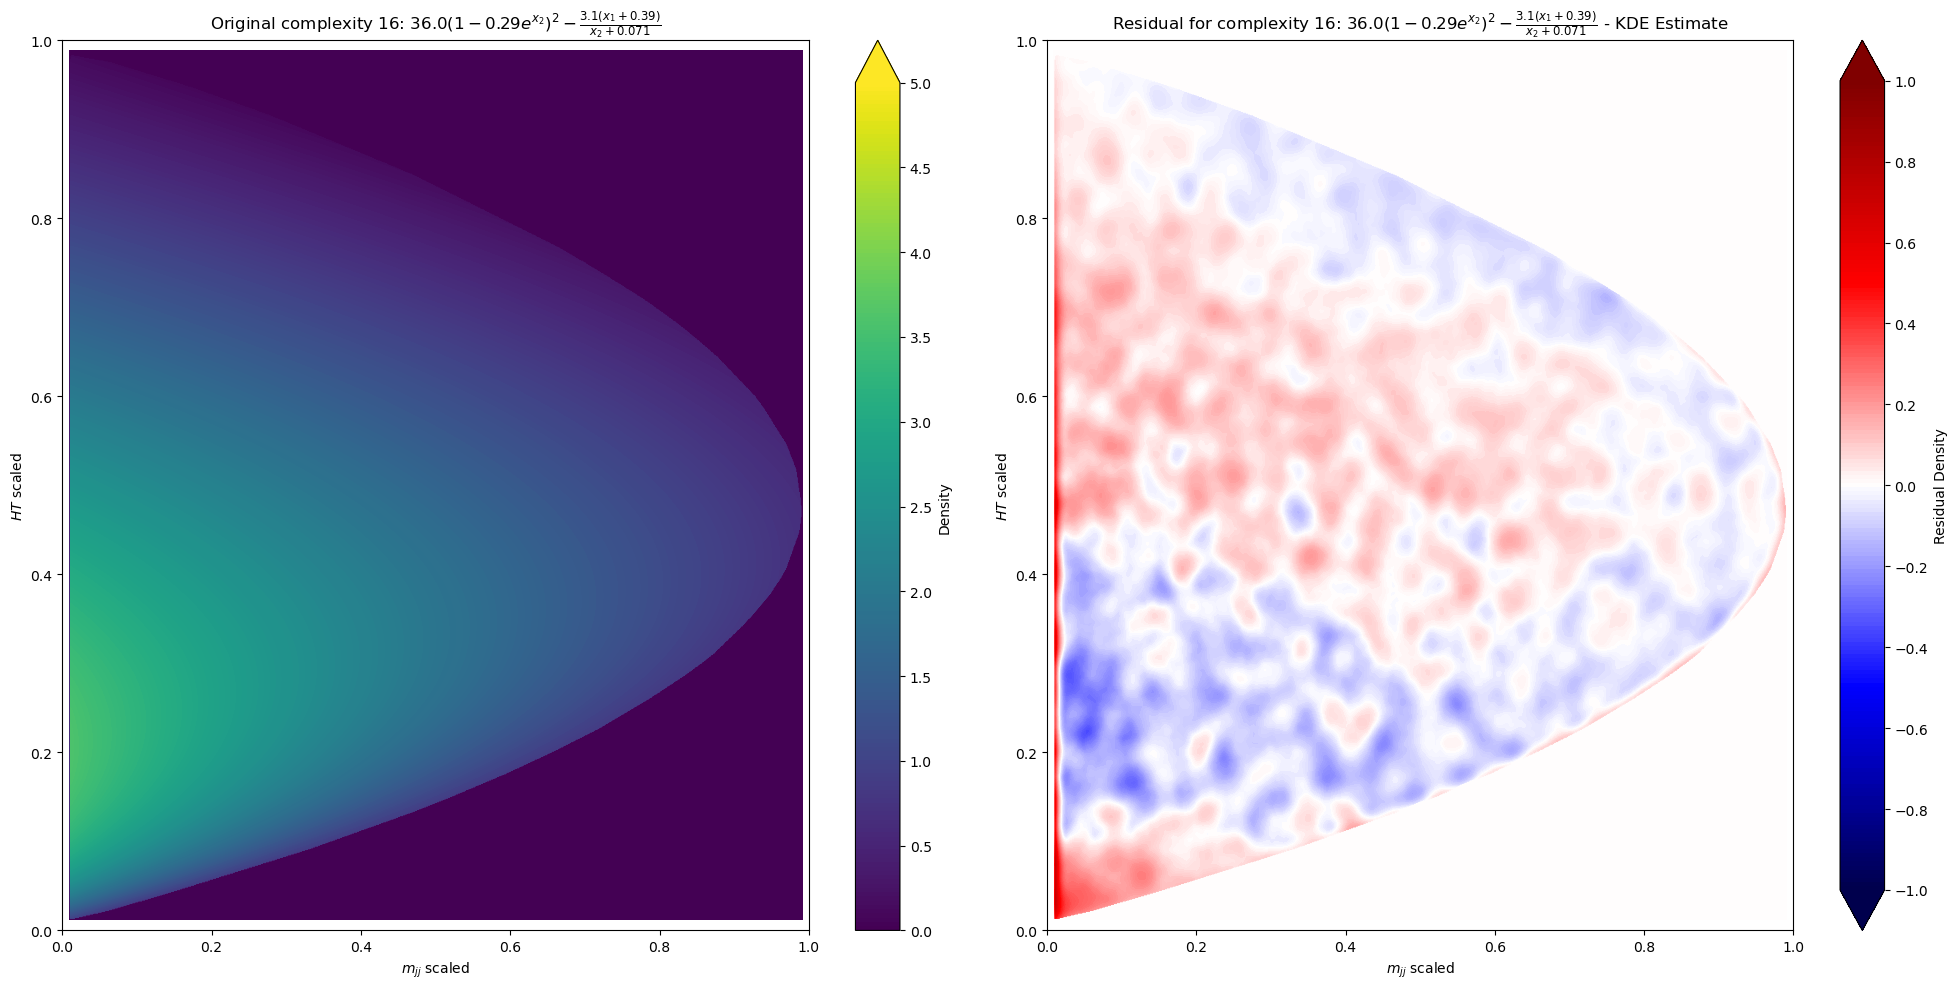

Complexity 16: Likelihood score: 27,054.77310162612
complexity 16 :: min predict: 0.00, max predict: 3.59
complexity 16 :: min residual: -0.35, max residual: 0.71
Complexity 16: MSE error: 3.606594e-02


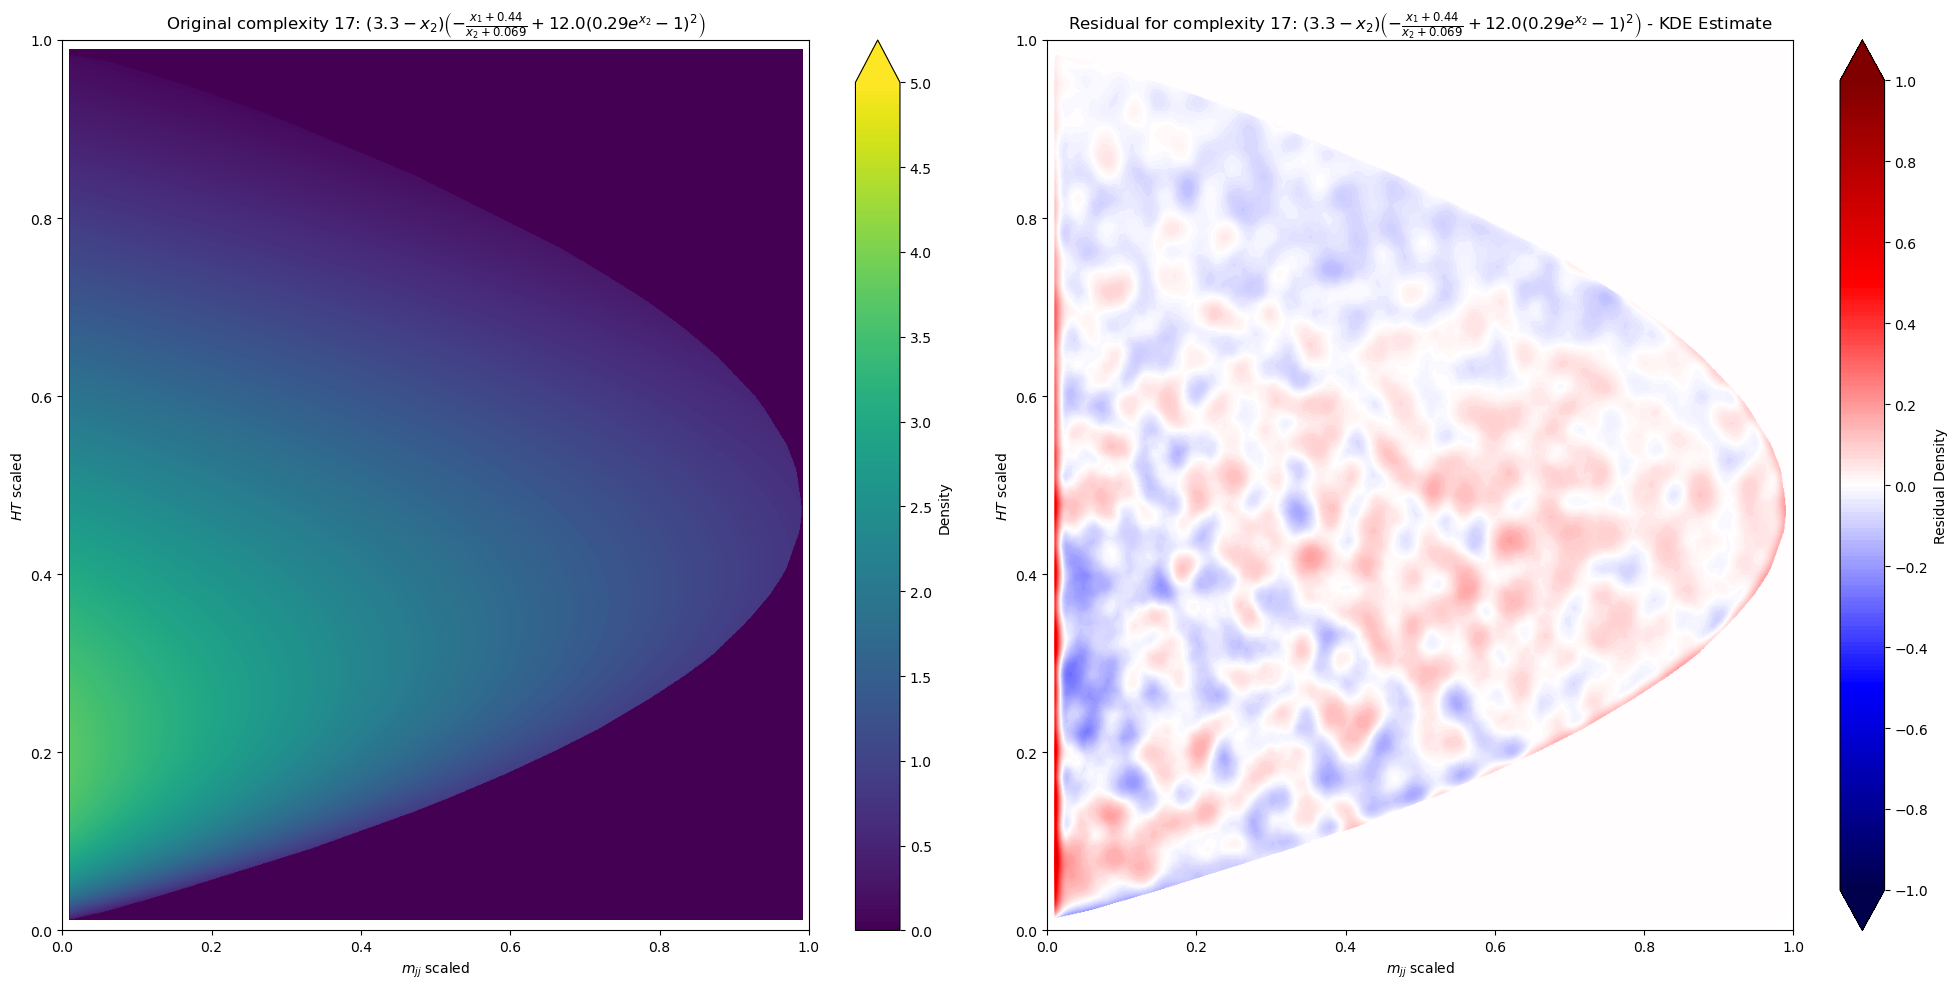

Complexity 17: Likelihood score: nan
complexity 17 :: min predict: 0.00, max predict: 3.69
complexity 17 :: min residual: -0.28, max residual: 0.71
Complexity 17: MSE error: 2.031195e-02


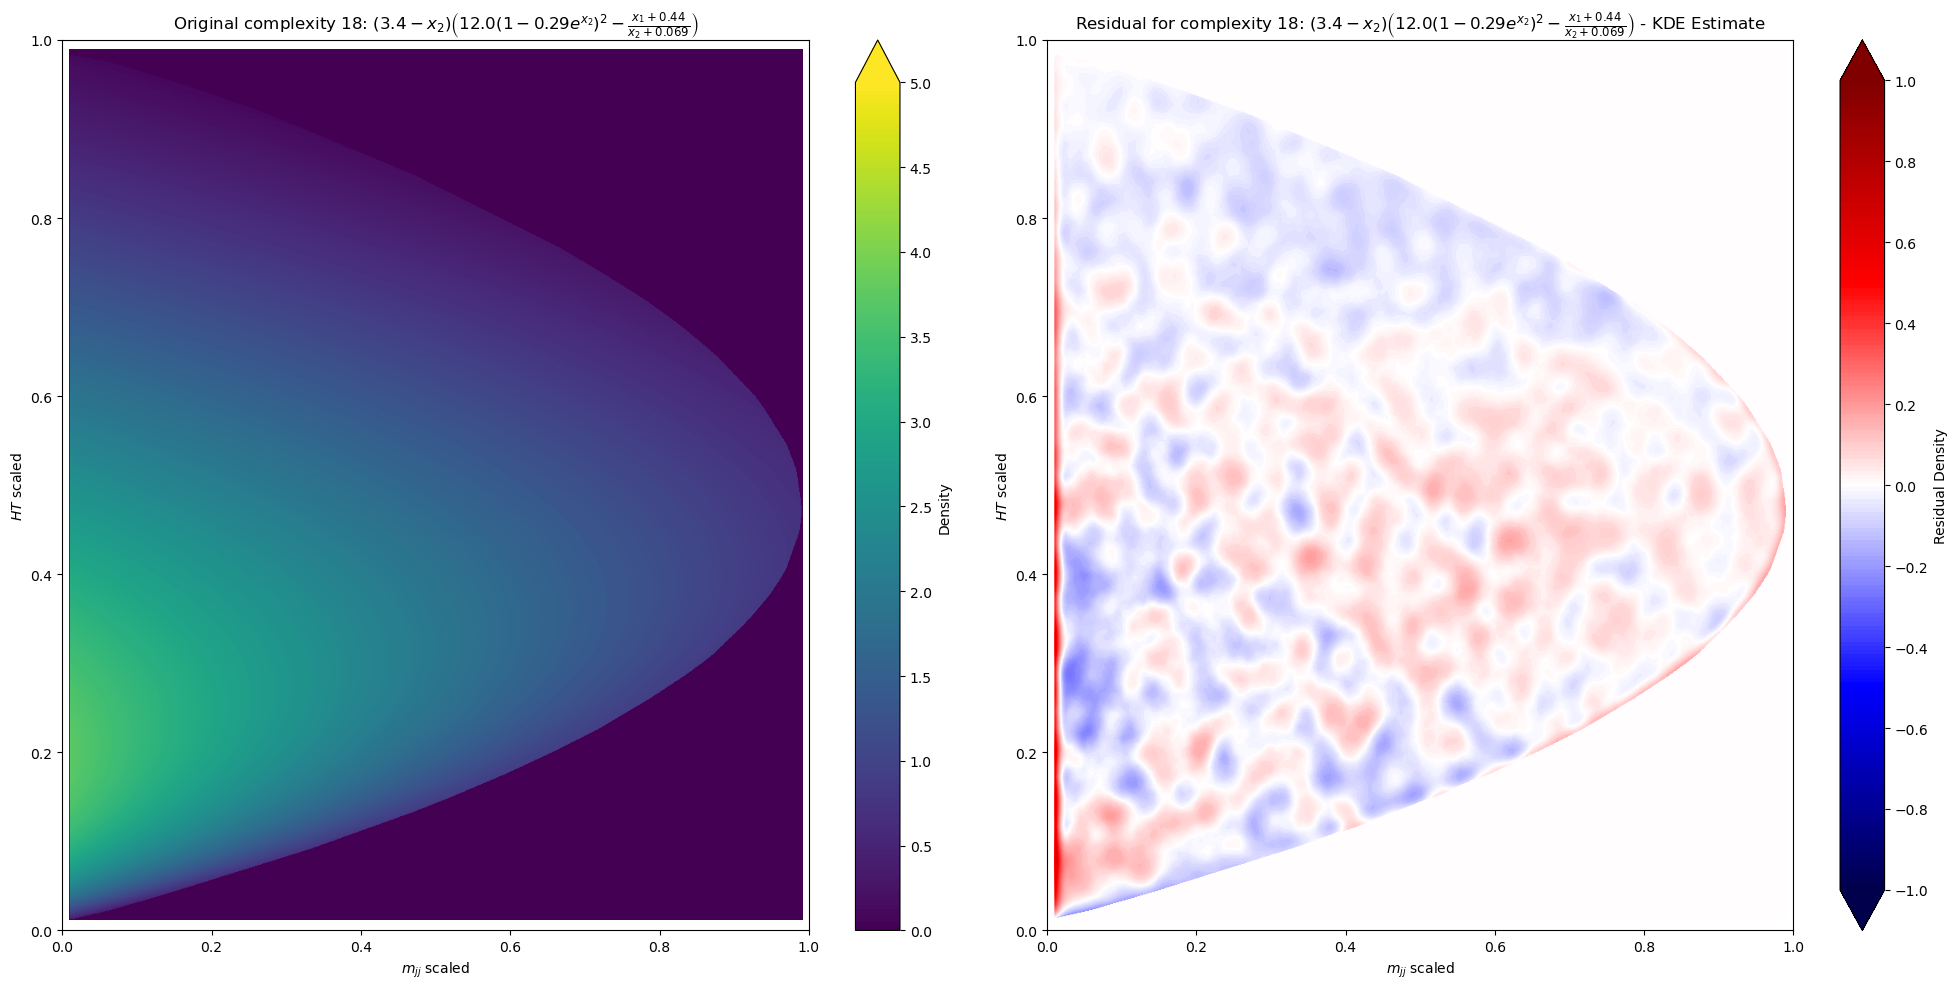

Complexity 18: Likelihood score: nan
complexity 18 :: min predict: 0.00, max predict: 3.71
complexity 18 :: min residual: -0.27, max residual: 0.71
Complexity 18: MSE error: 2.026158e-02


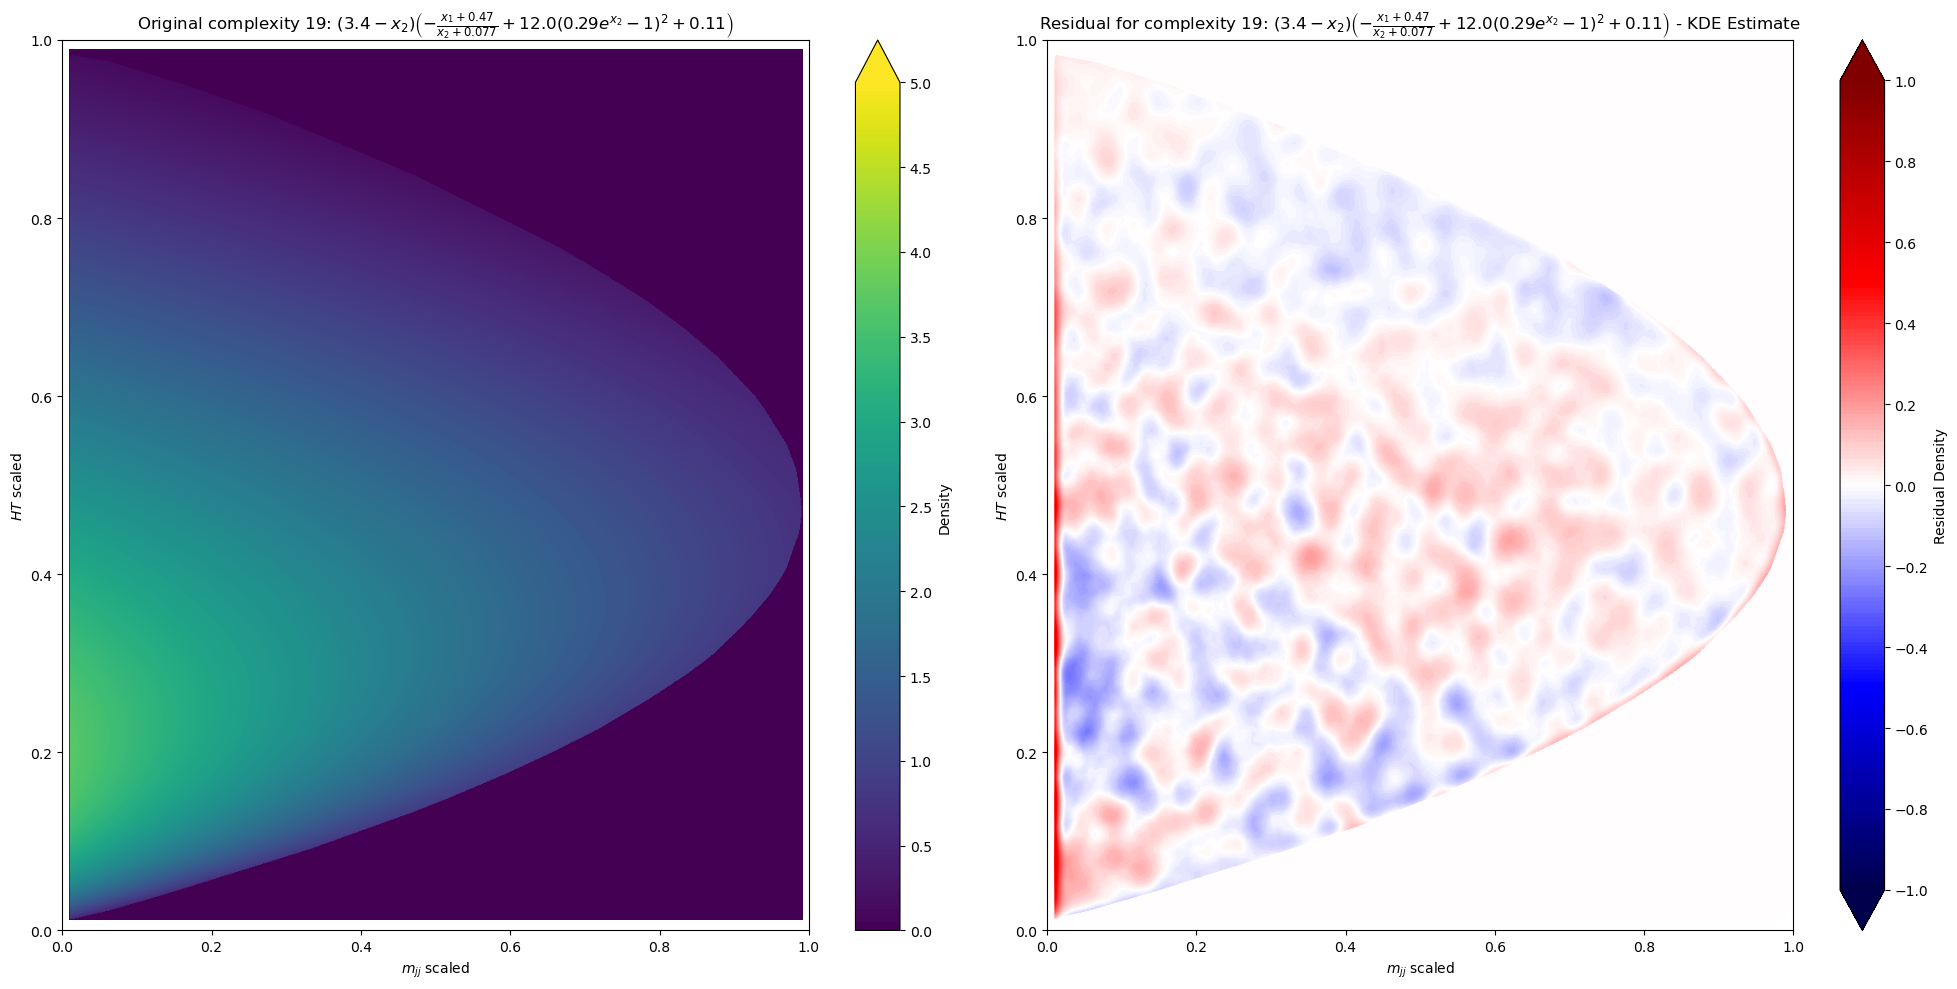

Complexity 19: Likelihood score: nan
complexity 19 :: min predict: 0.00, max predict: 3.69
complexity 19 :: min residual: -0.27, max residual: 0.68
Complexity 19: MSE error: 1.933110e-02


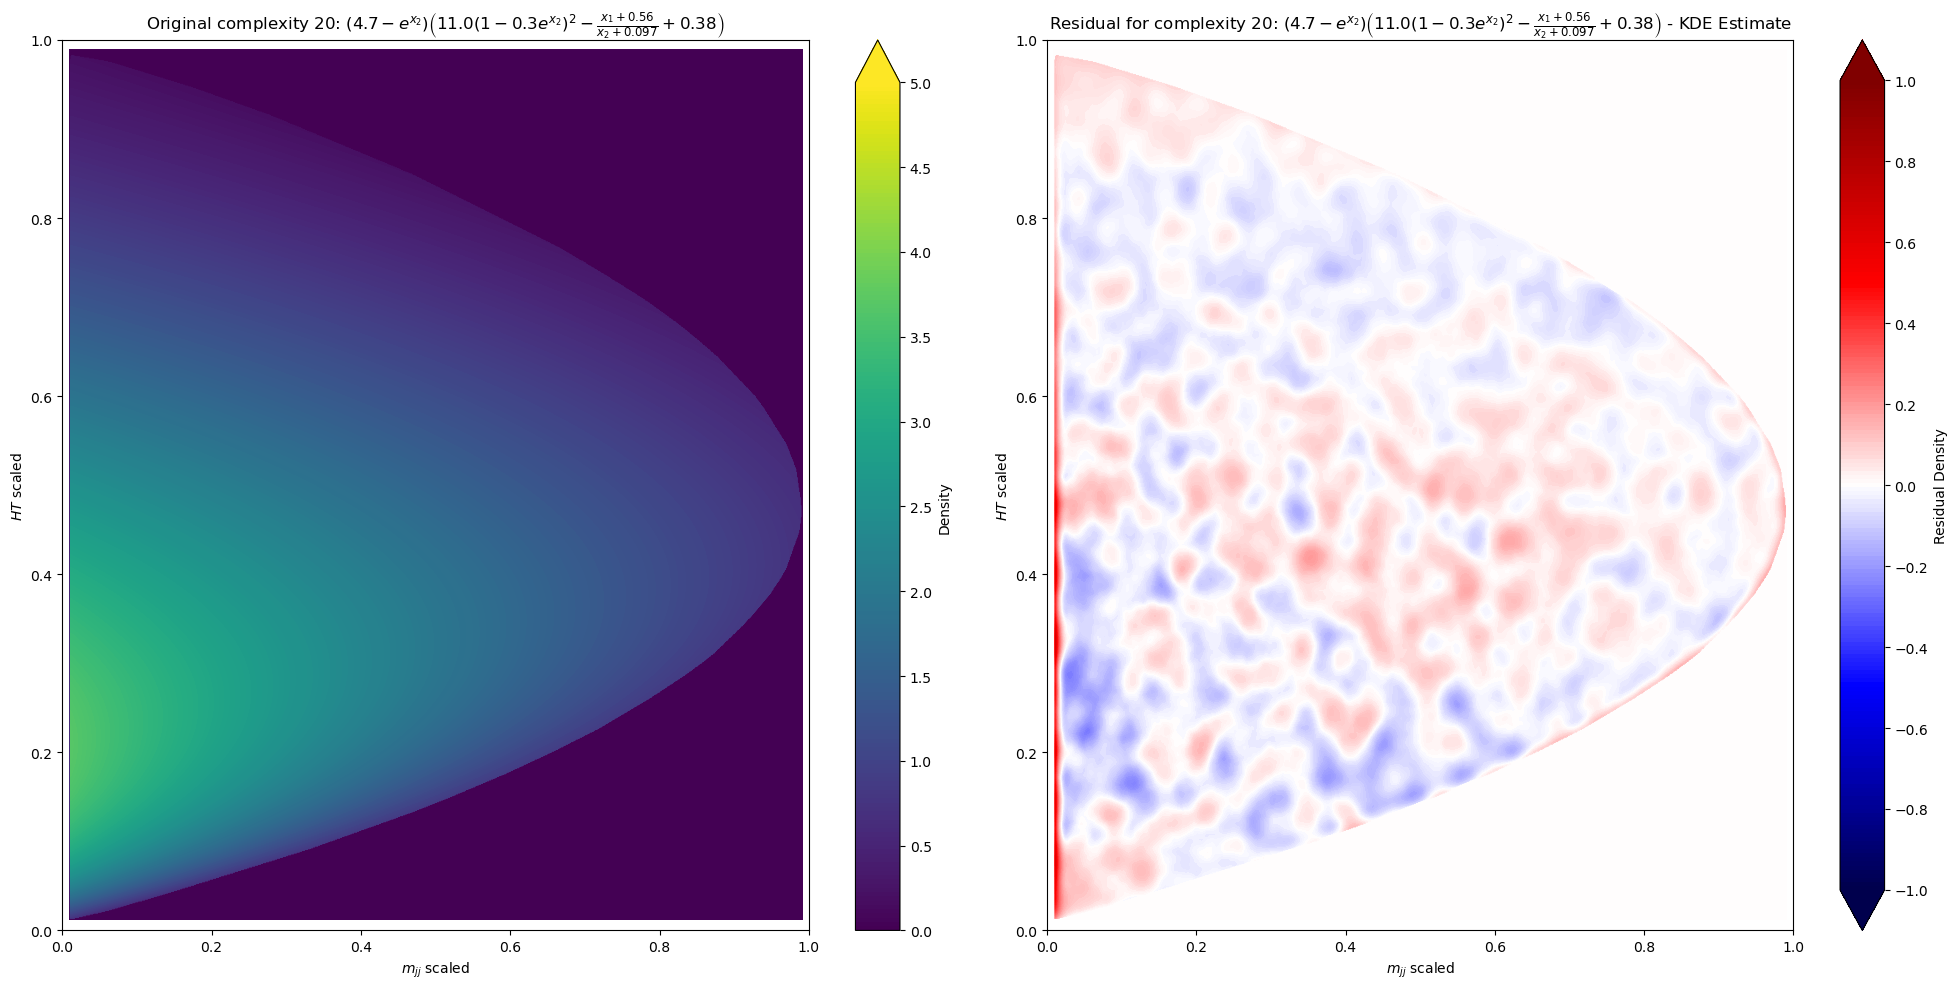

Complexity 20: Likelihood score: 26,850.57439794179
complexity 20 :: min predict: 0.00, max predict: 3.68
complexity 20 :: min residual: -0.26, max residual: 0.65
Complexity 20: MSE error: 1.844856e-02


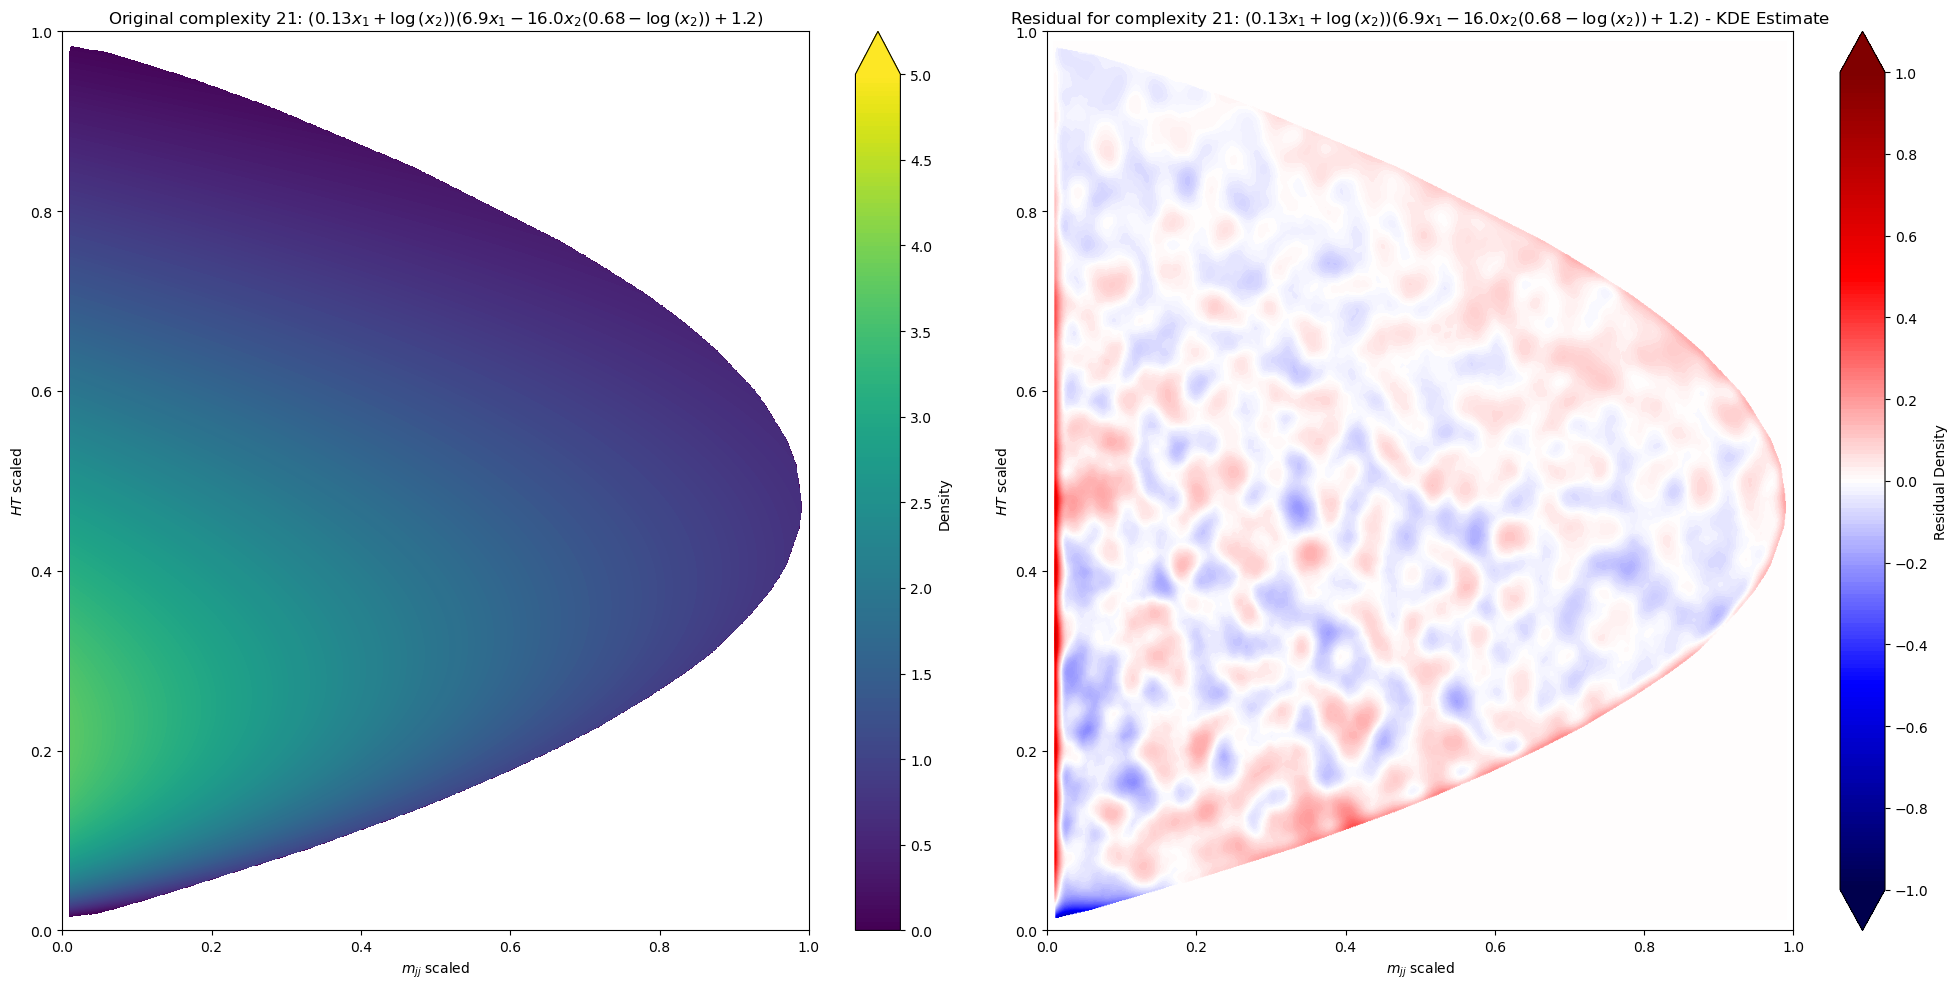

Complexity 21: Likelihood score: nan
complexity 21 :: min predict: -0.22, max predict: 3.72
complexity 21 :: min residual: -0.79, max residual: 0.71
Complexity 21: MSE error: 1.903660e-02


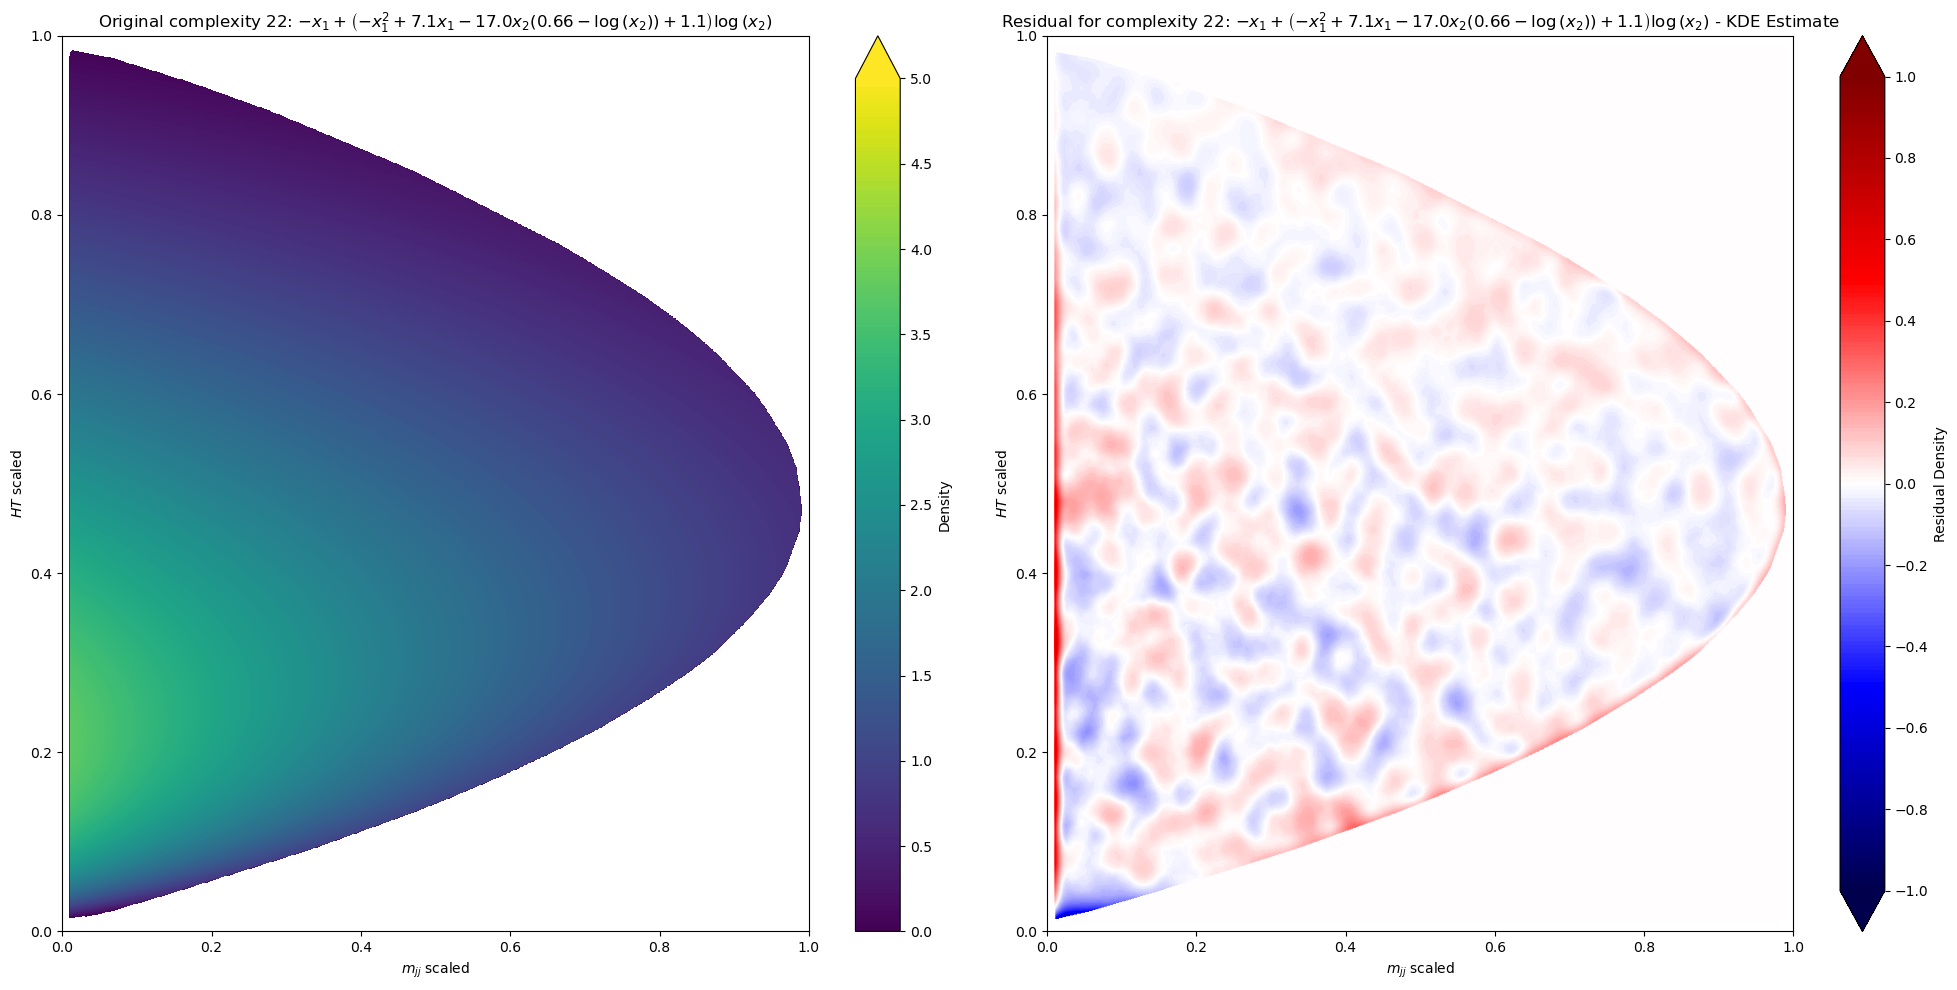

Complexity 22: Likelihood score: nan
complexity 22 :: min predict: -0.20, max predict: 3.74
complexity 22 :: min residual: -0.77, max residual: 0.71
Complexity 22: MSE error: 1.748540e-02


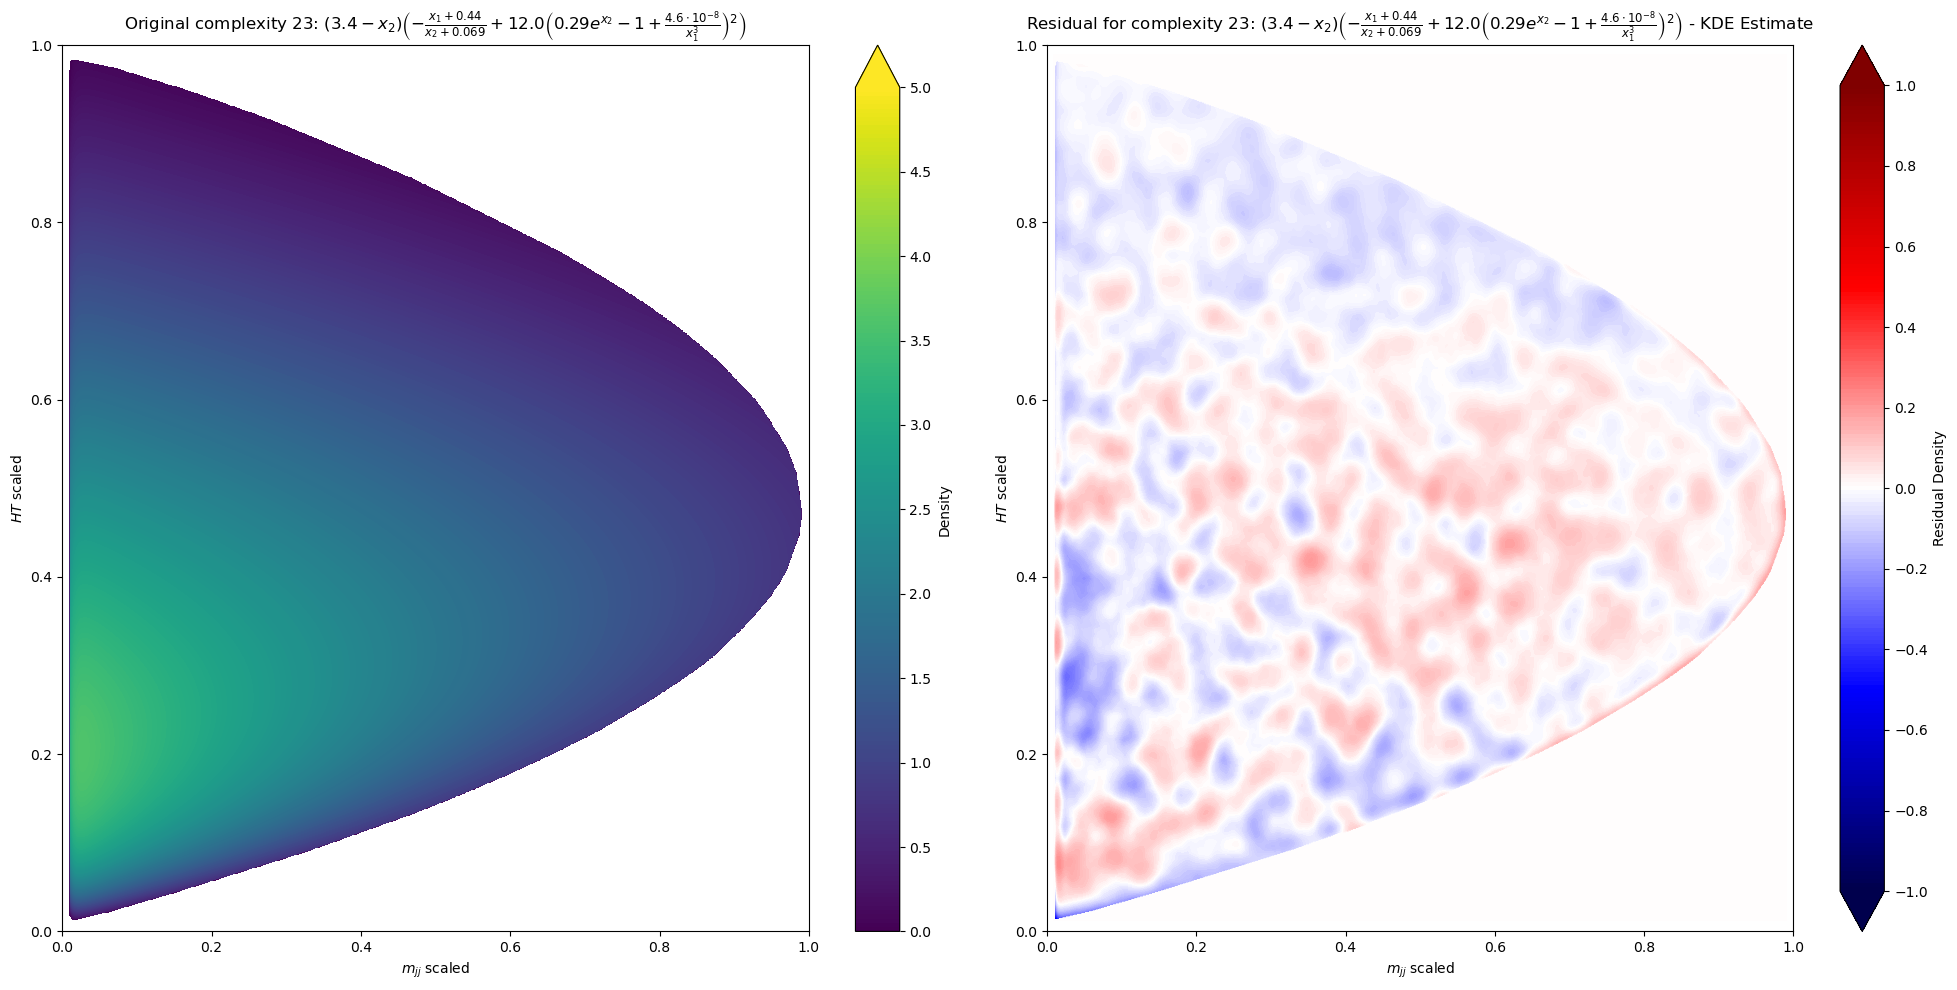

Complexity 23: Likelihood score: nan
complexity 23 :: min predict: -0.25, max predict: 3.61
complexity 23 :: min residual: -0.76, max residual: 0.22
Complexity 23: MSE error: 1.703791e-02


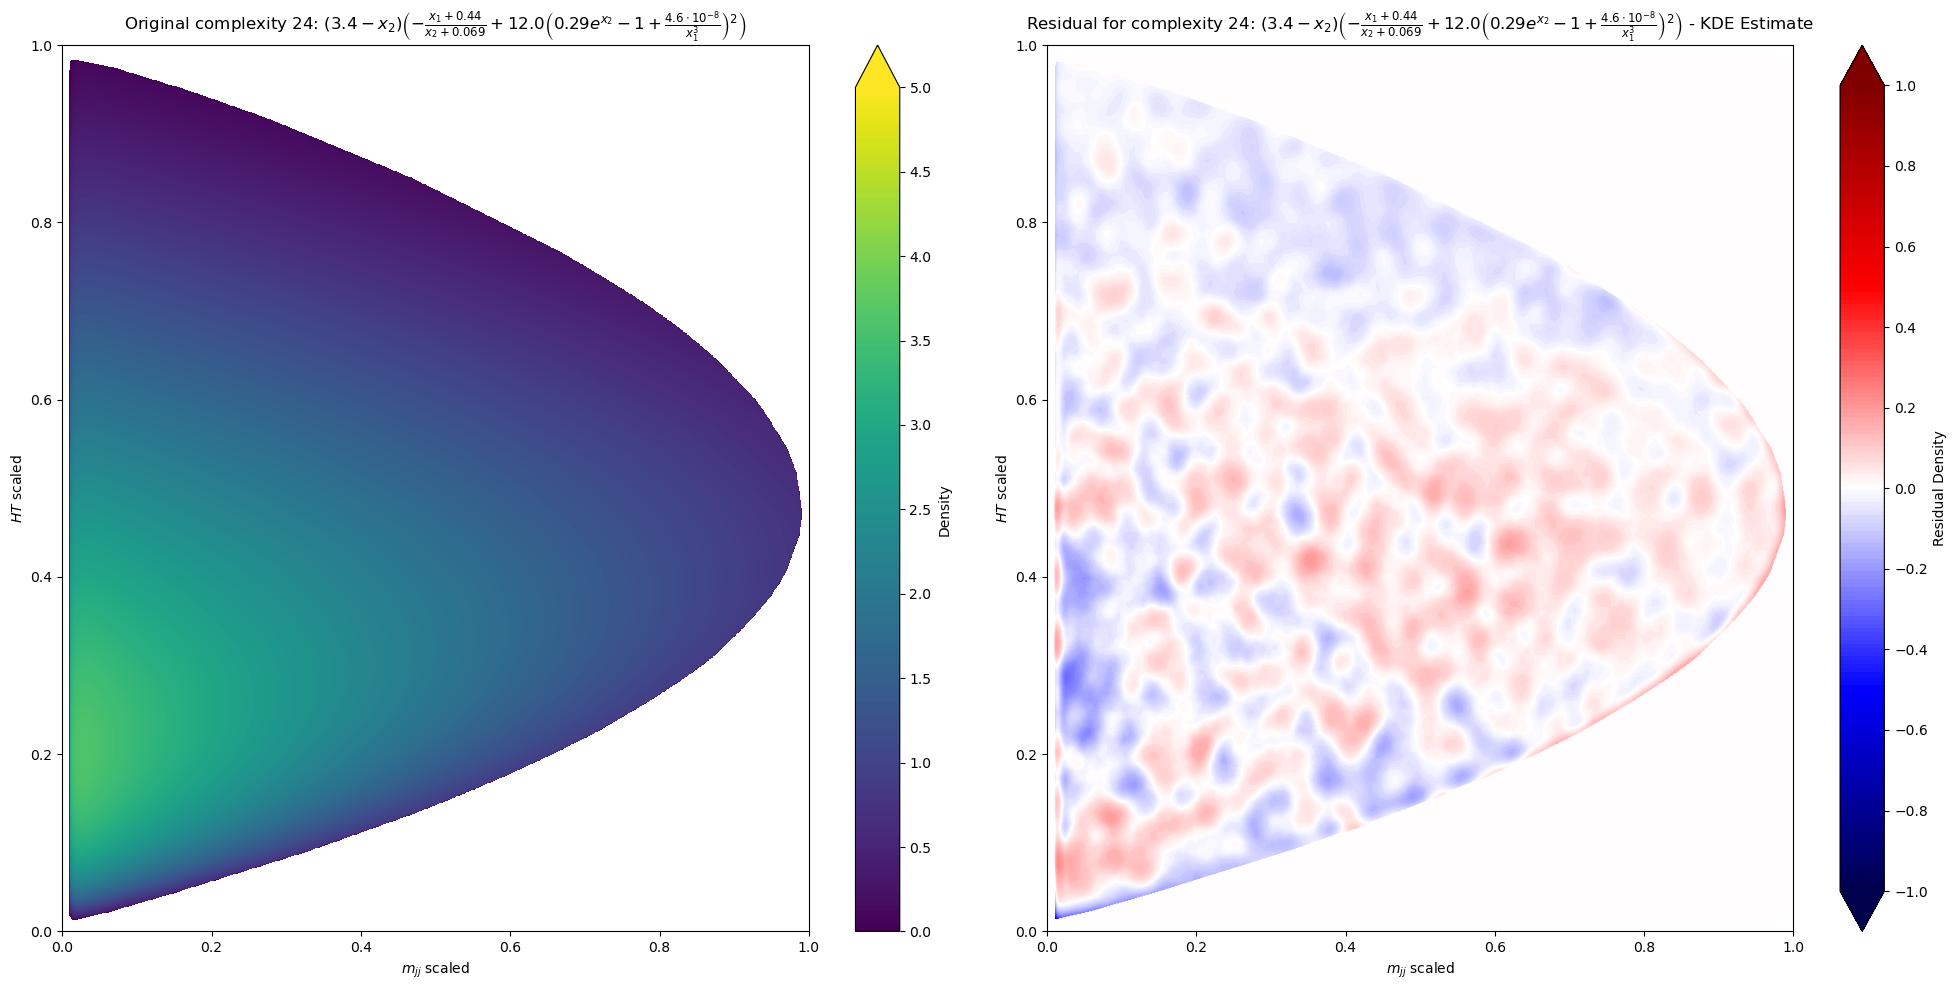

Complexity 24: Likelihood score: nan
complexity 24 :: min predict: -0.25, max predict: 3.61
complexity 24 :: min residual: -0.76, max residual: 0.22
Complexity 24: MSE error: 1.703791e-02


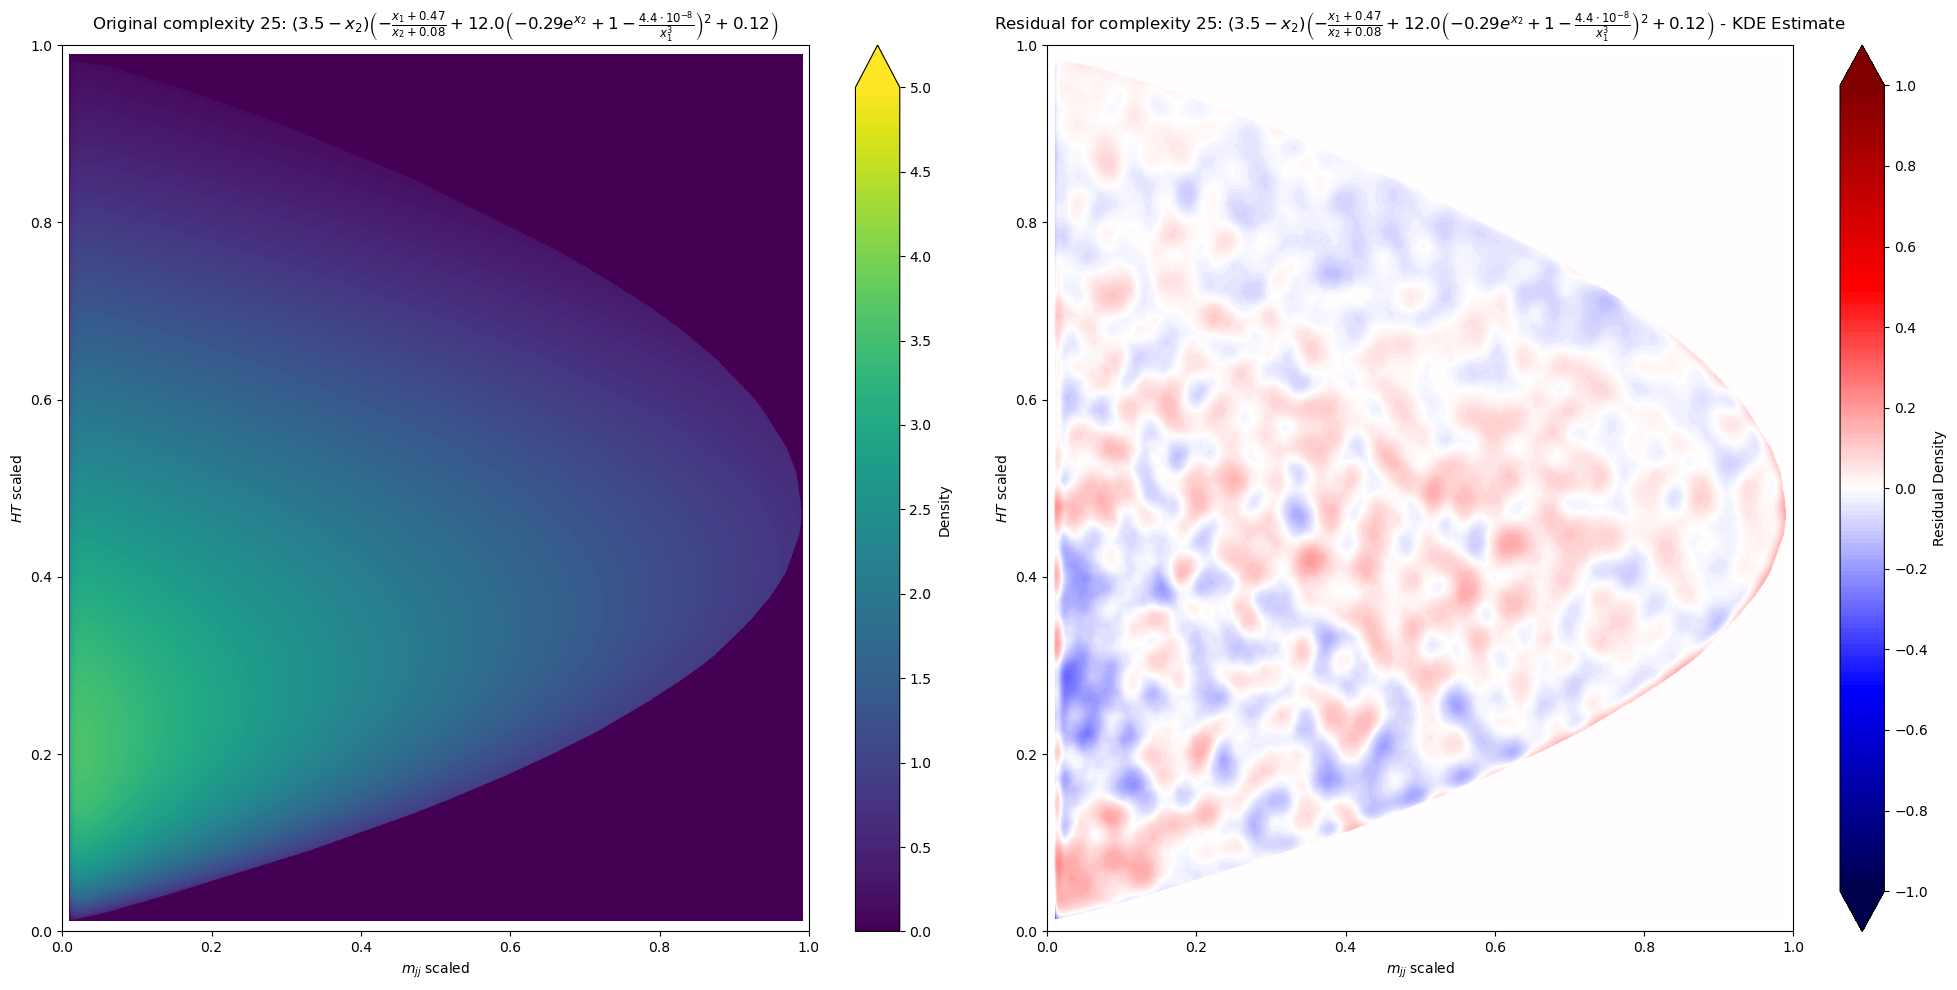

Complexity 25: Likelihood score: nan
complexity 25 :: min predict: 0.00, max predict: 3.58
complexity 25 :: min residual: -0.49, max residual: 0.22
Complexity 25: MSE error: 1.575053e-02


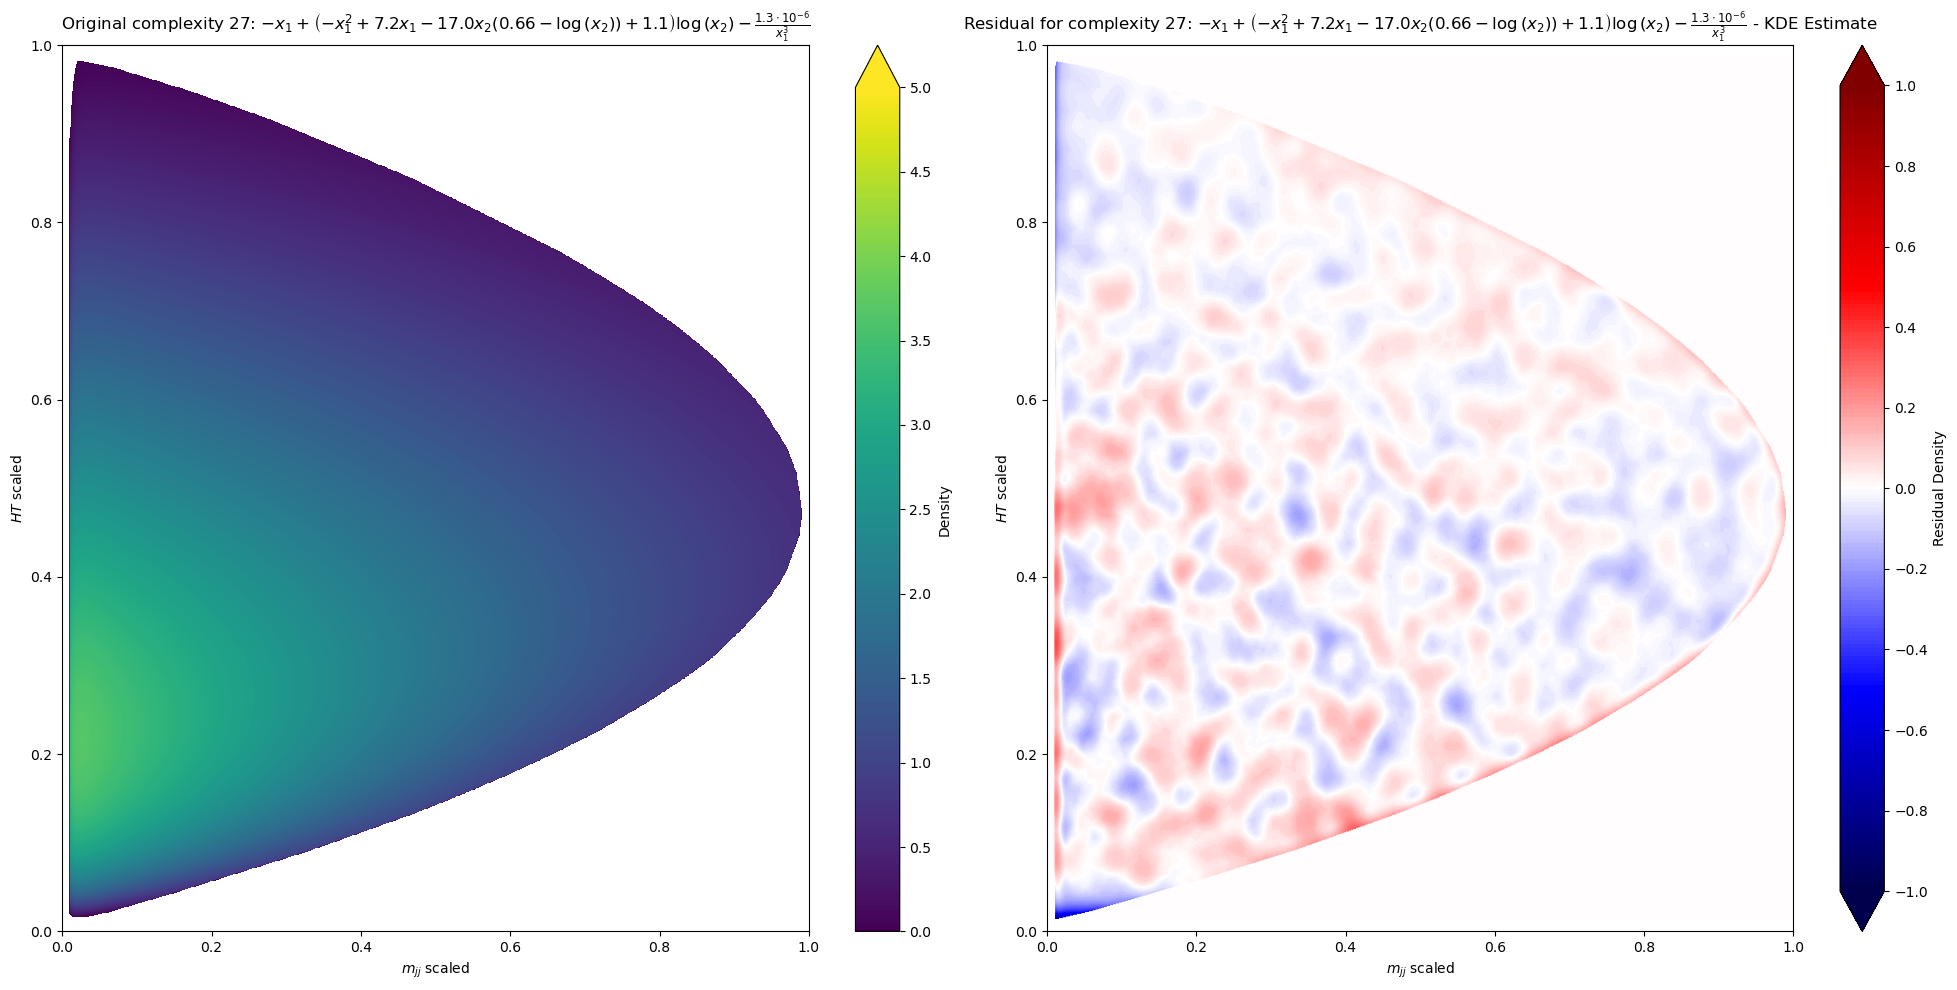

Complexity 27: Likelihood score: nan
complexity 27 :: min predict: -0.51, max predict: 3.67
complexity 27 :: min residual: -1.02, max residual: 0.35
Complexity 27: MSE error: 1.495752e-02


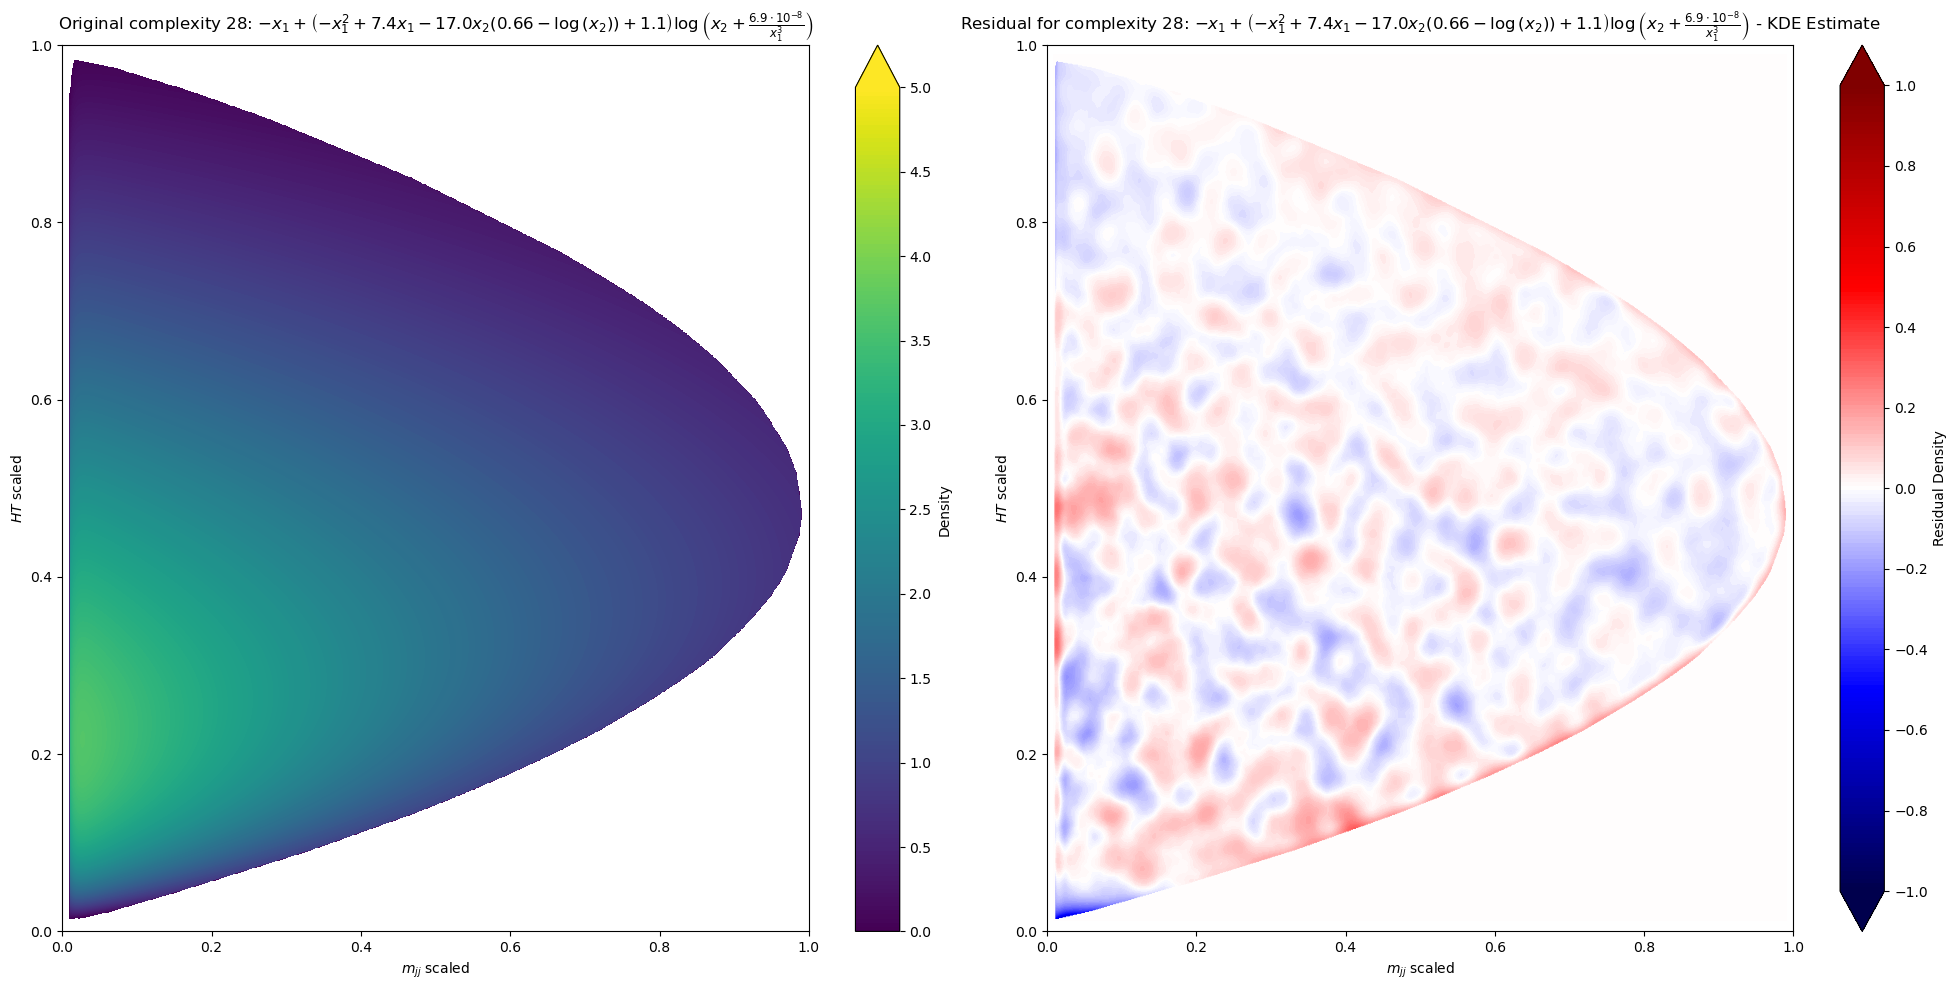

Complexity 28: Likelihood score: nan
complexity 28 :: min predict: -0.11, max predict: 3.65
complexity 28 :: min residual: -0.67, max residual: 0.32
Complexity 28: MSE error: 1.399240e-02


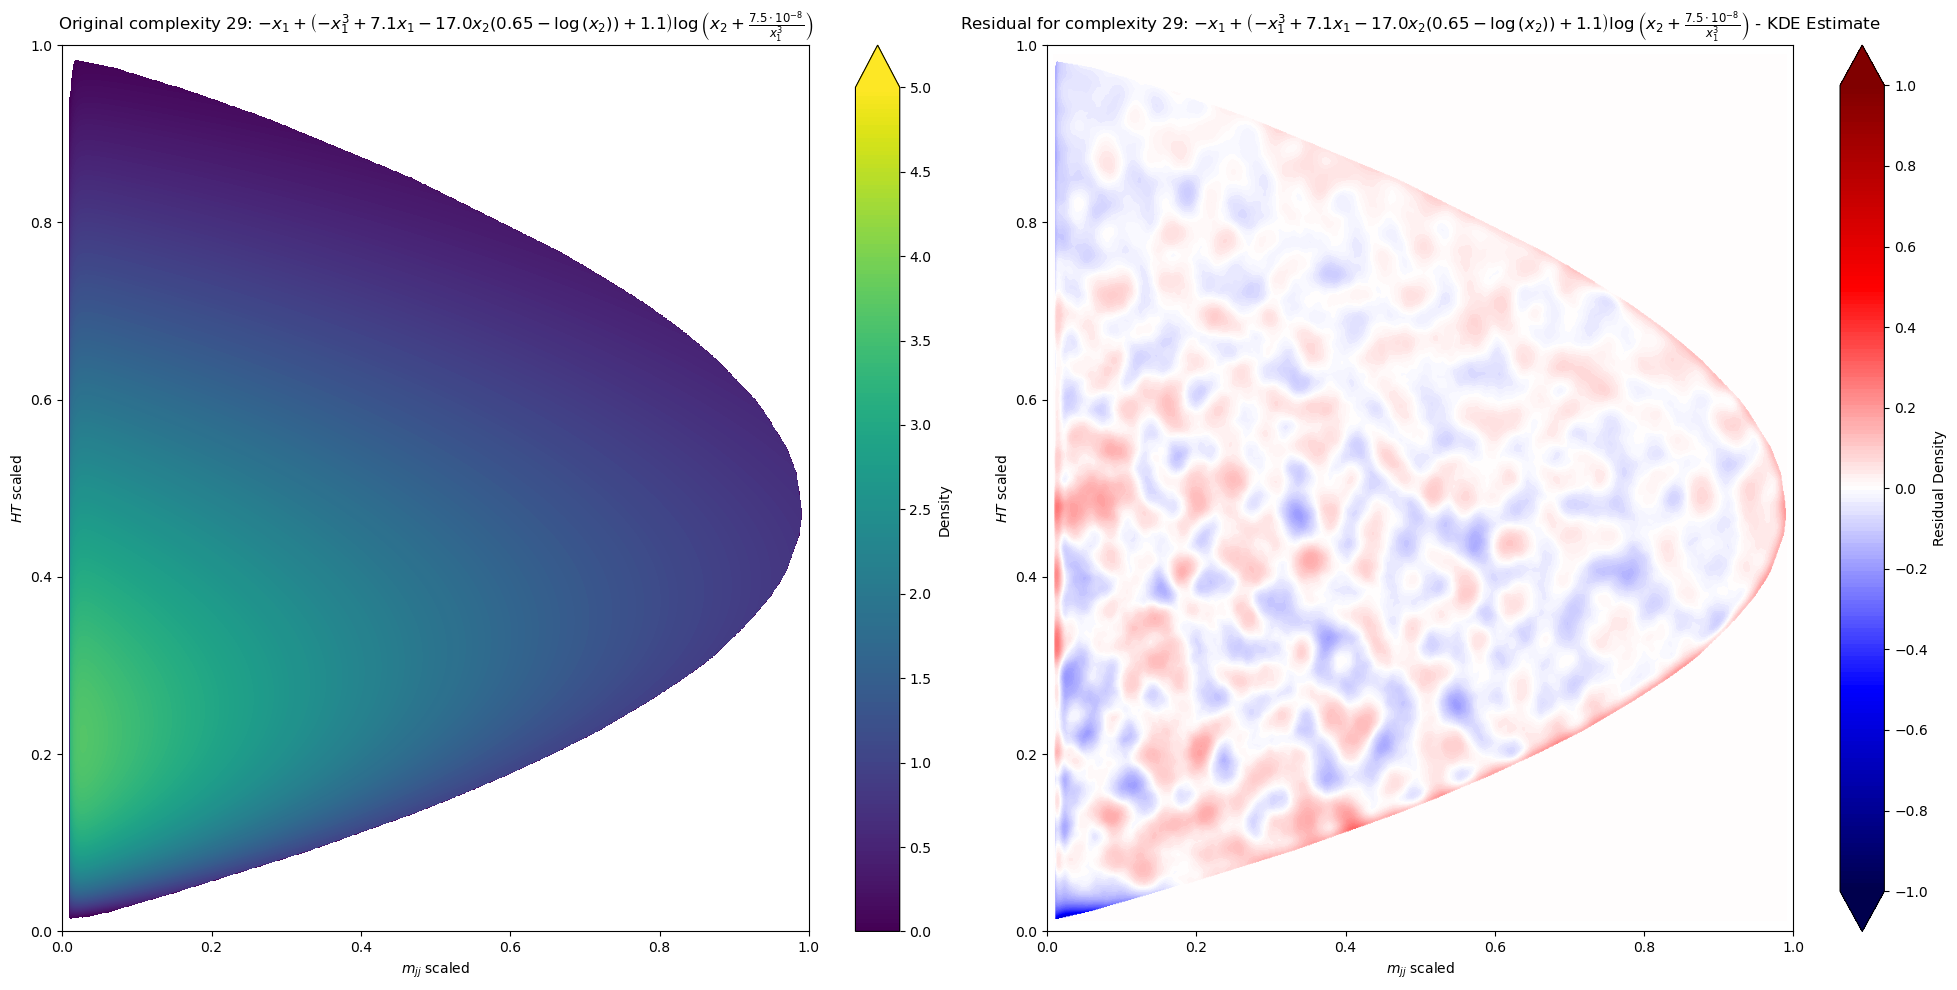

Complexity 29: Likelihood score: nan
complexity 29 :: min predict: -0.13, max predict: 3.65
complexity 29 :: min residual: -0.72, max residual: 0.29
Complexity 29: MSE error: 1.390505e-02


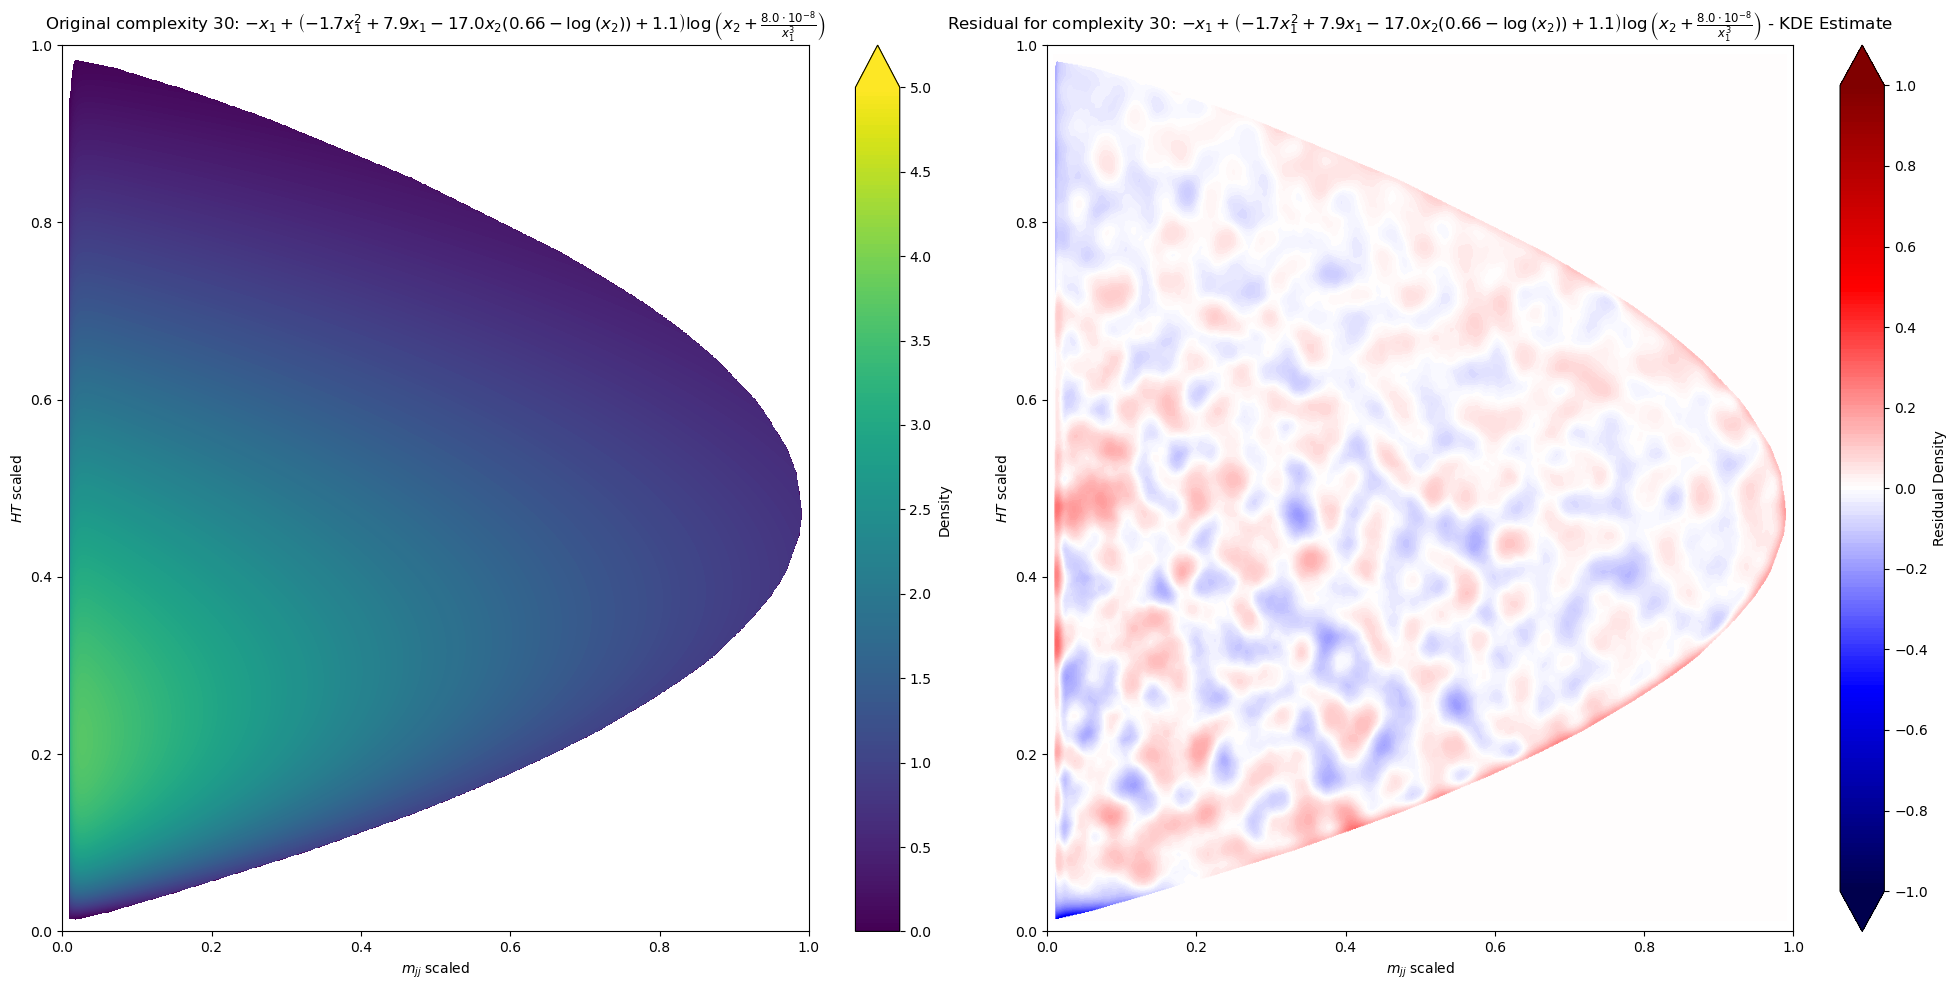

Complexity 30: Likelihood score: nan
complexity 30 :: min predict: -0.13, max predict: 3.68
complexity 30 :: min residual: -0.64, max residual: 0.29
Complexity 30: MSE error: 1.328246e-02
Finished generating and saving plots for 27 functions.


In [32]:
# Iterate over the masked_functions list
for i, current_function in enumerate(masked_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue

    # Get the title for the current function
    title = latex_labels[i]

    # Create a new figure for each iteration
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Plot 1: Original Function Plot (current_function) ---
    ax1 = axes[0]
    
    # Calculate the function output
    function_output = current_function(grids[0], grids[1], mask)
    if np.shape(function_output) == (1,1) or np.shape(function_output)==():
        function_output = function_output*np.ones(grids[0].shape)

    # Set levels based on your required range
    levels_original = np.linspace(level_min, level_max, 200)
    
    contour1 = ax1.contourf(
        grids[0], grids[1],
        function_output/density_scale_factor,
        levels=levels_original,
        cmap='viridis',
        extend='max'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour1, ax=ax1, label="Density", ticks=np.linspace(level_min, level_max, 11))
    
    ax1.set_xlabel(r"$m_{jj}$ scaled")
    ax1.set_ylabel(r"$HT$ scaled")
    ax1.set_title(f"Original complexity {complexity[i]}: {title}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    # --- Plot 2: Residual Plot (current_function - sum_grid) ---
    ax2 = axes[1]
    
    # Calculate the residual
    residual_output = function_output/density_scale_factor - kde_predicted_density
    residual_output[mask] = 0.0
    
    # Set levels for the residual plot (should be symmetric around zero)
    levels_residual = np.linspace(level_min_delta, level_max_delta, 200)
    
    contour2 = ax2.contourf(
        grids[0], grids[1],
        residual_output,
        levels=levels_residual,
        cmap='seismic', # 'seismic' is good for residuals (zero in the middle)
        extend='both'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour2, ax=ax2, label="Residual Density", ticks=np.linspace(level_min_delta, level_max_delta, 11))
    
    ax2.set_xlabel(r"$m_{jj}$ scaled")
    ax2.set_ylabel(r"$HT$ scaled")
    ax2.set_title(f"Residual for complexity {complexity[i]}: {title} - KDE Estimate")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

    # Final adjustments and saving
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    
    # 3. Force the Python garbage collector to clean up memory
    gc.collect()
    prediction_eval_at_samples = current_function(test_samples[:,0], test_samples[:,1], np.zeros(np.shape(test_samples[:,0])))
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict: {np.min(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}, max predict: {np.max(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}")
    min_residual = np.min(residual_output)
    max_residual = np.max(residual_output)
    print(f"complexity {complexity[i]} :: min residual: {min_residual:.2f}, max residual: {max_residual:.2f}")
    mse_error = np.mean((density_scale_factor*residual_output)**2)
    print(f"Complexity {complexity[i]}: MSE error: {mse_error:.6e}")
    # Explicitly delete large arrays and clear memory before the next loop iteration
    del prediction_eval_at_samples
    del residual_output
    gc.collect()


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")

# Other Views (Miscellaneous)

## Scatter plot of data input to SR pipeline

In [37]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_original = np.loadtxt('data/processed_data/muon_decay_joint_data.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_original.shape[0], size=1000, replace=False)
data = data_original[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)

## Joint data in pipeline

In [38]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_in_pipeline = np.loadtxt('data/processed_data/muon_decay_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_in_pipeline.shape[0], size=1000, replace=False)
data = data_in_pipeline[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)